# MONGY: Training `PatchTSMixer` on Financial Candlestick Data
## Direct forecasting example

This notebooke demonstrates the usage of a `PatchTSMixer` model for a multivariate time series forecasting task. This notebook has a dependecy on HuggingFace [transformers](https://github.com/huggingface/transformers) repo. For details related to model architecture, refer to the [TSMixer paper](https://arxiv.org/abs/2306.09364).

In [1]:
# Standard
import os
import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset, BaseDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

In [2]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# We want to setup our context, horizon, and patch size based on our task. We want to use
# 4 hours of lookback to start, in order to predict the next 5 minutes of candles. Regarding
# patch length, we know that we will want a larger patch size, so we will start with 64 as
# a base case assumption
context_length = 60 * 4  # This will give us 4 hours of lookback (6 candles per min * 60 min per hour)
forecast_horizon = 3 # This will give us 3 minutes of predictions


In [4]:
# Load the Dataset from the CSV file
DATA_DIR = "/home/ubuntu/verb-workspace/data"

MORNING_TEST_DATASET = f"{DATA_DIR}/1min-candles-test-MORNING.csv"
DAY_TEST_DATASET = f"{DATA_DIR}/1min-candles-test-DAY.csv"
AFTERNOON_TEST_DATASET = f"{DATA_DIR}/1min-candles-test-AFTERNOON.csv"

timestamp_col = 't'

morning_data = pd.read_csv(
    MORNING_TEST_DATASET,
    parse_dates=[timestamp_col]
)

day_data = pd.read_csv(
    DAY_TEST_DATASET,
    parse_dates=[timestamp_col]
)

afternoon_data = pd.read_csv(
    AFTERNOON_TEST_DATASET,
    parse_dates=[timestamp_col]
)



In [5]:
morning_data['t'].unique()

array([Timestamp('2023-01-23 05:30:00-0500', tz='UTC-05:00'),
       Timestamp('2023-01-23 05:31:00-0500', tz='UTC-05:00'),
       Timestamp('2023-01-23 05:32:00-0500', tz='UTC-05:00'), ...,
       Timestamp('2023-03-13 10:58:00-0400', tz='UTC-04:00'),
       Timestamp('2023-03-13 10:59:00-0400', tz='UTC-04:00'),
       Timestamp('2023-03-13 11:00:00-0400', tz='UTC-04:00')],
      dtype=object)

In [6]:
day_data['t'].unique()

array([Timestamp('2023-01-23 09:00:00-0500', tz='UTC-05:00'),
       Timestamp('2023-01-23 09:01:00-0500', tz='UTC-05:00'),
       Timestamp('2023-01-23 09:02:00-0500', tz='UTC-05:00'), ...,
       Timestamp('2023-03-13 14:28:00-0400', tz='UTC-04:00'),
       Timestamp('2023-03-13 14:29:00-0400', tz='UTC-04:00'),
       Timestamp('2023-03-13 14:30:00-0400', tz='UTC-04:00')],
      dtype=object)

In [7]:
afternoon_data['t'].unique()

array([Timestamp('2023-01-23 10:30:00-0500', tz='UTC-05:00'),
       Timestamp('2023-01-23 10:31:00-0500', tz='UTC-05:00'),
       Timestamp('2023-01-23 10:32:00-0500', tz='UTC-05:00'), ...,
       Timestamp('2023-03-13 15:57:00-0400', tz='UTC-04:00'),
       Timestamp('2023-03-13 15:58:00-0400', tz='UTC-04:00'),
       Timestamp('2023-03-13 15:59:00-0400', tz='UTC-04:00')],
      dtype=object)

In [8]:
id_columns = ['ticker', 'date_string']
forecast_columns = ['targ_o', 'targ_c', 'targ_h', 'targ_l', 'targ_v', 'targ_vwap', 'targ_red', 'targ_green']
control_columns = ['cont_market_open', 'cont_market_extended']

morning_tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_col,
    id_columns=id_columns,
    target_columns=forecast_columns,
    control_columns=control_columns,
    scaling=True,
)
morning_tsp.train(morning_data)
print("Done Morning Set")

day_tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_col,
    id_columns=id_columns,
    target_columns=forecast_columns,
    control_columns=control_columns,
    scaling=True,
)
day_tsp.train(day_data)
print("Done Day Set")

afternoon_tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_col,
    id_columns=id_columns,
    target_columns=forecast_columns,
    control_columns=control_columns,
    scaling=True,
)
afternoon_tsp.train(afternoon_data)
print("Done Afternoon Set")

Done Morning Set
Done Day Set
Done Afternoon Set


In [9]:
morning_dataset = ForecastDFDataset(
    morning_tsp.preprocess(morning_data),
    id_columns=id_columns,
    timestamp_column=timestamp_col,
    target_columns=forecast_columns,
    control_columns=control_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
print("Done Morning Set")

day_dataset = ForecastDFDataset(
    day_tsp.preprocess(day_data),
    id_columns=id_columns,
    timestamp_column=timestamp_col,
    target_columns=forecast_columns,
    control_columns=control_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
print("Done Day Set")


afternoon_dataset = ForecastDFDataset(
    afternoon_tsp.preprocess(afternoon_data),
    id_columns=id_columns,
    timestamp_column=timestamp_col,
    target_columns=forecast_columns,
    control_columns=control_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
print("Done Afternoon Set")

Done Morning Set
Done Day Set
Done Afternoon Set


## Training `PatchTSMixer` From Scratch

Adjust the following model parameters according to need.
- `d_model` (`int`, *optional*, defaults to 8):
    Hidden dimension of the model. Recommended to set it as a multiple of patch_length (i.e. 2-8X of
    patch_len). Larger value indicates more complex model.
- `expansion_factor` (`int`, *optional*, defaults to 2):
    Expansion factor to use inside MLP. Recommended range is 2-5. Larger value indicates more complex model.
- `num_layers` (`int`, *optional*, defaults to 3):
    Number of layers to use. Recommended range is 3-15. Larger value indicates more complex model.
- `mode`: (`str`, either to 'common_channel' or `mix_channel`)

In [10]:
# Indices for accessing the OHLC values in the tensors
I_OPEN = 0
I_CLOSE = 1
I_HIGH = 2
I_LOW = 3
I_VOLUME = 4
I_RED = 5
I_GREEN = 6

from typing import Optional, Any

from transformers.models.patchtsmixer.modeling_patchtsmixer import (
    PatchTSMixerForPredictionOutput, 
    PatchTSMixerConfig, 
    PatchTSMixerModel,
    PatchTSMixerForPredictionHead
)

class MongyModel(PatchTSMixerForPrediction):

    def __init__(self, config: PatchTSMixerConfig, loss_func: Any = None):
        super().__init__(config)
        self.loss = config.loss
        self.loss_func = loss_func
        self.use_return_dict = config.use_return_dict
        self.prediction_channel_indices = config.prediction_channel_indices
        self.num_parallel_samples = config.num_parallel_samples
        
        if config.loss == "mse":
            self.distribution_output = None
        else:
            dim = config.prediction_length
            distribution_output_map = {
                "student_t": StudentTOutput,
                "normal": NormalOutput,
                "negative_binomial": NegativeBinomialOutput,
            }
            output_class = distribution_output_map.get(config.distribution_output, None)
            if output_class is not None:
                self.distribution_output = output_class(dim=dim)
            else:
                raise ValueError(f"Unknown distribution output {config.distribution_output}")
        
        self.model = PatchTSMixerModel(config)
        self.head = PatchTSMixerForPredictionHead(
            config=config,
            distribution_output=self.distribution_output,
        )
        
        # Initialize weights and apply final processing
        if config.post_init:
            self.post_init()

    def forward(
        self,
        past_values: torch.Tensor,
        observed_mask: Optional[torch.Tensor] = None,
        future_values: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[bool] = False,
        return_loss: bool = True,
        return_dict: Optional[bool] = None,
    ) -> PatchTSMixerForPredictionOutput:
        r"""
        observed_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_input_channels)`, *optional*):
            Boolean mask to indicate which `past_values` were observed and which were missing. Mask values selected
            in `[0, 1]`:
                - 1 for values that are **observed**,
                - 0 for values that are **missing** (i.e. NaNs that were replaced by zeros).
        future_values (`torch.FloatTensor` of shape `(batch_size, target_len, num_input_channels)` for forecasting,:
            `(batch_size, num_targets)` for regression, or `(batch_size,)` for classification, *optional*): Target
            values of the time series, that serve as labels for the model. The `future_values` is what the
            Transformer needs during training to learn to output, given the `past_values`. Note that, this is NOT
            required for a pretraining task.

            For a forecasting task, the shape is be `(batch_size, target_len, num_input_channels)`. Even if we want
            to forecast only specific channels by setting the indices in `prediction_channel_indices` parameter,
            pass the target data with all channels, as channel Filtering for both prediction and target will be
            manually applied before the loss computation.
        return_loss (`bool`,  *optional*):
            Whether to return the loss in the `forward` call.

        Returns:

        """
        if self.loss_func is not None:
            loss = self.loss_func
        elif self.loss == "mse":
            loss = torch.nn.MSELoss(reduction="mean")
        elif self.loss == "nll":
            loss = nll
        else:
            raise ValueError("Invalid loss function: Allowed values: mse and nll")

        return_dict = return_dict if return_dict is not None else self.use_return_dict

        # past_values: tensor [batch_size x context_length x num_input_channels]
        model_output = self.model(
            past_values,
            observed_mask=observed_mask,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )  # model_output: [batch_size x nvars x num_patch x d_model]

        
        if isinstance(model_output, tuple):
            model_output = PatchTSMixerModelOutput(*model_output)

        # tensor [batch_size x prediction_length x num_input_channels]
        y_hat = self.head(model_output.last_hidden_state)

        # # Snap the candles to the correct opening positions, before computing the loss
        # # This is the "training wheels" for the head. By helping the model with the portion
        # # of it's task that we can help with, we severly limit the task that is posed to the
        # # model
        
        last_context_close = past_values[..., -1, I_CLOSE]
        first_candle_open = y_hat[..., 0, I_OPEN]
        first_candle_delta = last_context_close - first_candle_open
        first_candle_delta = first_candle_delta.unsqueeze(-1).unsqueeze(-1)
        y_hat[..., 0:4] = y_hat[..., 0:4] + first_candle_delta


        first_candle_close = y_hat[..., 0, I_CLOSE]
        second_candle_open = y_hat[..., 1, I_OPEN]
        second_candle_delta = first_candle_close - second_candle_open
        second_candle_delta = second_candle_delta.unsqueeze(-1).unsqueeze(-1)
        y_hat[..., -2:, 0:4] = y_hat[..., -2:, 0:4] + second_candle_delta

        second_candle_close = y_hat[..., 1, I_CLOSE]
        third_candle_open = y_hat[..., 2, I_OPEN]
        third_candle_delta = second_candle_close - third_candle_open
        third_candle_delta = third_candle_delta.unsqueeze(-1)
        y_hat[..., -1, 0:4] = y_hat[..., -1, 0:4] + third_candle_delta


        loss_val = None
        if self.prediction_channel_indices is not None:
            if self.distribution_output:
                distribution = self.distribution_output.distribution(
                    y_hat,
                    loc=model_output.loc[..., self.prediction_channel_indices],
                    scale=model_output.scale[..., self.prediction_channel_indices],
                )
                if future_values is not None and return_loss is True:
                    loss_val = loss(
                        distribution,
                        future_values[..., self.prediction_channel_indices],
                    )
                    # take average of the loss
                    loss_val = weighted_average(loss_val)
            else:
                y_hat = (
                    y_hat * model_output.scale[..., self.prediction_channel_indices]
                    + model_output.loc[..., self.prediction_channel_indices]
                )
                if future_values is not None and return_loss is True:
                    loss_val = loss(y_hat, future_values[..., self.prediction_channel_indices])
        else:
            if self.distribution_output:
                distribution = self.distribution_output.distribution(
                    y_hat, loc=model_output.loc, scale=model_output.scale
                )
                if future_values is not None and return_loss is True:
                    loss_val = loss(distribution, future_values)
                    loss_val = weighted_average(loss_val)
            else:
                y_hat = y_hat * model_output.scale + model_output.loc
                if future_values is not None and return_loss is True:
                    loss_val = loss(y_hat, future_values)

        if self.prediction_channel_indices is not None:
            loc = model_output.loc[..., self.prediction_channel_indices]
            scale = model_output.scale[..., self.prediction_channel_indices]
        else:
            loc = model_output.loc
            scale = model_output.scale

        if not return_dict:
            return tuple(
                v
                for v in [
                    loss_val,
                    y_hat,
                    model_output.last_hidden_state,
                    model_output.hidden_states,
                    loc,
                    scale,
                ]
            )

        return PatchTSMixerForPredictionOutput(
            loss=loss_val,
            prediction_outputs=y_hat,  # tensor [batch_size x prediction_length x num_input_channels]
            last_hidden_state=model_output.last_hidden_state,  # x: [batch_size x nvars x num_patch x d_model]
            hidden_states=model_output.hidden_states,
            loc=loc,
            scale=scale,
        )

In [125]:
morning_run_1 = "morning_3"
morning_dir_1 = f"./checkpoints/run_{morning_run_1}/output/checkpoint-13500"
morning_model_1 = MongyModel.from_pretrained(morning_dir_1)
morning_model_1.eval()

morning_run_2 = "morning_4_BIG"
morning_dir_2 = f"./checkpoints/run_{morning_run_2}/output/checkpoint-45000"
morning_model_2 = MongyModel.from_pretrained(morning_dir_2)
morning_model_2.eval()

day_run_1 = "day_3"
day_dir_1 = f"./checkpoints/run_{day_run_1}/output/checkpoint-13500"
day_model_1 = MongyModel.from_pretrained(day_dir_1)
day_model_1.eval()

day_run_2 = "day_4_BIG"
day_dir_2 = f"./checkpoints/run_{day_run_2}/output/checkpoint-45000"
day_model_2 = MongyModel.from_pretrained(day_dir_2)
day_model_2.eval()

afternoon_run_1 = "afternoon_2"
afternoon_dir_1 = f"./checkpoints/run_{afternoon_run_1}/output/checkpoint-18500"
afternoon_model_1 = MongyModel.from_pretrained(afternoon_dir_1)
afternoon_model_1.eval()

afternoon_run_2 = "afternoon_3_BIG"
afternoon_dir_2 = f"./checkpoints/run_{afternoon_run_2}/output/checkpoint-52500"
afternoon_model_2 = MongyModel.from_pretrained(afternoon_dir_2)
afternoon_model_2.eval()

morning_model_dict = {
    # "Morning Model (Small) (Step 13500)": {
    #     'model': morning_model_1,
    #     'scaled_dataset': morning_dataset,
    #     'tag': "MORNING",
    # },
    "Morning Model (Large) (Step 45000)": {
        'model': morning_model_2,
        'scaled_dataset': morning_dataset,
        'tag': "MORNING",
    },
}

day_model_dict = {
    # "Day Model (Small) (Step 13500)": {
    #     'model': day_model_1,
    #     'scaled_dataset': day_dataset,
    #     'tag': "DAY",
    # },
    "Day Model (Large) (Step 45000)": {
        'model': day_model_2,
        'scaled_dataset': day_dataset,
        'tag': "DAY",
    },
}

afternoon_model_dict = {
    # "Afternoon Model (Small) (Step 18500)": {
    #     'model': afternoon_model_1,
    #     'scaled_dataset': afternoon_dataset,
    #     'tag': "AFTERNOON",
    # },
    "Afternoon Model (Large) (Step 52500)": {
        'model': afternoon_model_2,
        'scaled_dataset': afternoon_dataset,
        'tag': "AFTERNOON",
    },
}

def get_scaler(tag: str):
    match tag:
        case "MORNING": 
            return morning_tsp
        case "DAY":
            return day_tsp
        case "AFTERNOON":
            return afternoon_tsp
        case _:
            raise ValueError("Invalid TAG")

## Model Test Bench

In [126]:
import time
from typing import Tuple

def run_inference(context: torch.Tensor, futures: torch.Tensor, _model: MongyModel, log_time: bool = False) -> torch.Tensor:
    _model.eval()
    
    with torch.no_grad():
        start = time.perf_counter()
        _forecasts = _model(context.unsqueeze(0), future_values=futures.unsqueeze(0), return_loss=False).prediction_outputs
        end = time.perf_counter()

        if log_time:
            print(f"Ran Inference in {end - start} seconds")
        return _forecasts.squeeze(0)

In [127]:
# Indices for accessing the OHLC values in the tensors
I_OPEN = 0
I_CLOSE = 1
I_HIGH = 2
I_LOW = 3
I_VOLUME = 4
I_VWAP = 5
I_RED = 6
I_GREEN = 7



def post_process(_context: torch.Tensor, _futures: torch.Tensor, _forecasts: torch.Tensor, ticker: str, date_str: str, scaler) -> Tuple[torch.tensor]:
    _context_df = pd.DataFrame({
        'ticker': ticker,
        'date_string': date_str,
        'targ_o': _context[:,I_OPEN].numpy(),
        'targ_c': _context[:,I_CLOSE].numpy(),
        'targ_h': _context[:,I_HIGH].numpy(),
        'targ_l': _context[:,I_LOW].numpy(),
        'targ_v': _context[:,I_VOLUME].numpy(),
        'targ_vwap': _context[:,I_VWAP].numpy(),
        'targ_red': _context[:,I_RED].numpy(),
        'targ_green': _context[:,I_GREEN].numpy(),
    })
    _futures_df = pd.DataFrame({
        'ticker': ticker,
        'date_string': date_str,
        'targ_o': _futures[:,I_OPEN].numpy(),
        'targ_c': _futures[:,I_CLOSE].numpy(),
        'targ_h': _futures[:,I_HIGH].numpy(),
        'targ_l': _futures[:,I_LOW].numpy(),
        'targ_v': _futures[:,I_VOLUME].numpy(),
        'targ_vwap': _futures[:,I_VWAP].numpy(),
        'targ_red': _futures[:,I_RED].numpy(),
        'targ_green': _futures[:,I_GREEN].numpy(),
    })
    _forecasts_df = pd.DataFrame({
        'ticker': ticker,
        'date_string': date_str,
        'targ_o': _forecasts[:,I_OPEN].numpy(),
        'targ_c': _forecasts[:,I_CLOSE].numpy(),
        'targ_h': _forecasts[:,I_HIGH].numpy(),
        'targ_l': _forecasts[:,I_LOW].numpy(),
        'targ_v': _forecasts[:,I_VOLUME].numpy(),
        'targ_vwap': _forecasts[:,I_VWAP].numpy(),
        'targ_red': _forecasts[:,I_RED].numpy(),
        'targ_green': _forecasts[:,I_GREEN].numpy(),
    })

    inverse_scaled_context = scaler(_context_df)
    inverse_scaled_futures = scaler(_futures_df)
    inverse_scaled_forecasts = scaler(_forecasts_df)
    
    # Convert context data to OHLC candle data
    context_ohlc = pd.DataFrame({
        'Open': inverse_scaled_context['targ_o'],
        'Close': inverse_scaled_context['targ_c'],
        'High': inverse_scaled_context['targ_h'],
        'Low': inverse_scaled_context['targ_l'],
    })
    
    # Convert futures to OHLC candle data
    futures_ohlc = pd.DataFrame({
        'Open': inverse_scaled_futures['targ_o'],
        'Close': inverse_scaled_futures['targ_c'],
        'High': inverse_scaled_futures['targ_h'],
        'Low': inverse_scaled_futures['targ_l'],
    })

    # Convert the forecasts to OHLC data
    forecasts_ohlc = pd.DataFrame({
        'Open': inverse_scaled_forecasts['targ_o'],
        'Close': inverse_scaled_forecasts['targ_c'],
        'High': inverse_scaled_forecasts['targ_h'],
        'Low': inverse_scaled_forecasts['targ_l'],
    })
    
    
    reals_ohlc = pd.concat([context_ohlc, futures_ohlc])
    return reals_ohlc, forecasts_ohlc

In [128]:
import mplfinance as mpf
import matplotlib.pyplot as plt

def plot_candles(forecasts_dict: dict) -> None:
    # Create custom styles for context, future, and forecast candles
    reals_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'figure.facecolor': 'w', 'axes.facecolor': 'w'})
    forecast_style = {
        'marketcolors': {
            'candle': {'up': 'white', 'down': 'black'},
            'edge': {'up': 'black', 'down': 'black'},
            'wick': {'up': 'black', 'down': 'black'},
            'ohlc': {'up': 'white', 'down': 'black'},
            'volume': {'up': 'white', 'down': 'black'},
            'vcedge': {'up': 'white', 'down': 'black'},
            'vcdopcod': False,
            'alpha': 0.9
        }, 
        'mavcolors': None,
        'y_on_right': True,
    }
    
    # Create a figure and axes
    num_models = len(forecasts_dict)
    fig, axes = plt.subplots(num_models, 1, figsize=(12, 4 * num_models), sharex=True)

    

    # forecasts_ohlc_dict[model_name] = {
    #     "reals": reals_ohlc, 
    #     "forecasts": forecast_ohlc,
    #     "ticker": ticker,
    #     "date_str": date_str,
    #     "forecast_ts": ts,
    # }
    for i, (model_name, forecast_metadata) in enumerate(forecasts_dict.items()):
        ts = forecast_metadata['forecast_ts']
        context_start = ts - pd.Timedelta(hours=3, minutes=59)
        
        # Create a time series with a duration of 4 hours and 20 minutes at a 1-minute frequency
        end_time = context_start + pd.Timedelta(hours=4, minutes=2)  # Should get us the 4 hrs, 3min of time stamps
        reals_index = pd.date_range(start=context_start, end=end_time, freq='1min')
        
        # Set the created time series as the index of reals_ohlc
        reals = forecast_metadata['reals'].reset_index(drop=True)
        reals.index = reals_index
        
        # Trim reals to only contain 1 hour of data
        reals = reals.iloc[-60:]
        
        ax = axes[i] if num_models > 1 else axes
        
        # Create a new DataFrame to store the padded forecast candles
        forecasts = forecast_metadata['forecasts']

        padded_forecasts = pd.DataFrame(0.0, index=reals_index, columns=forecasts.columns)
        padded_forecasts.iloc[-3:] = forecasts
        
        # Trim padded_forecasts to only contain 1 hour of data
        padded_forecasts = padded_forecasts.iloc[-60:]


        # Plot the real candles on the current axis
        mpf.plot(reals, type='candle', ax=ax, style=reals_style)
        
        # Plot the padded forecast candles on top of the real candles
        mpf.plot(padded_forecasts, type='candle', ax=ax, style=forecast_style)
        
        # Set the same y-limits for both axes
        y_min = min(reals['Low'].min(), forecasts['Low'].min())
        y_max = max(reals['High'].max(), forecasts['High'].max())
        ax.set_ylim(y_min, y_max)
        
        # Set plot title and labels
        ticker = forecast_metadata['ticker']
        date_str = forecast_metadata['date_str']
        ax.set_title(f'{model_name} ({ticker} - {date_str})')
        ax.set_xlabel('Candle Index')
        ax.set_ylabel('Price')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [129]:
from typing import Tuple
# Indices for accessing the OHLC values in the tensors
I_OPEN = 0
I_CLOSE = 1
I_HIGH = 2
I_LOW = 3
I_VOLUME = 4
I_VWAP = 5
I_RED = 6
I_GREEN = 7


def _weighted_average(tensor):
    # Get the shape of the tensor
    shape = tensor.shape
    
    # Create a tensor of weights based on the last dimension
    weights = torch.arange(shape[-1], 0, -1, dtype=tensor.dtype, device=tensor.device)
    
    # Multiply the tensor by the weights along the last dimension
    weighted_tensor = tensor * weights
    
    # Sum the weighted tensor along the last dimension
    sum_weighted_tensor = torch.sum(weighted_tensor, dim=-1)
    
    # Sum the weights
    sum_weights = torch.sum(weights)
    
    # Compute the weighted average
    weighted_avg = sum_weighted_tensor / sum_weights
    
    return weighted_avg
    

def theta_body(y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Create the series of closes
    real_candle_closes = y_obs[..., I_CLOSE]
    forecasted_candle_closes = y_pred[..., I_CLOSE]

    # Get the series of opens
    real_candle_opens = y_obs[..., I_OPEN]
    forecasted_candle_opens = y_pred[..., I_OPEN]

    # Get the series of candle bodies
    real_bodies = real_candle_closes - real_candle_opens
    forecasted_bodies = forecasted_candle_closes - forecasted_candle_opens

    # Get the error of each body
    error = real_bodies - forecasted_bodies

    sq_error = _weighted_average(torch.square(error))
    abs_error = _weighted_average(torch.abs(error))
    return sq_error, abs_error

def theta_single_pnl(x: torch.Tensor, y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Get the close of the last real candle
    last_candle_close = x[..., -1, I_CLOSE]
    real_last_candle_close = y_obs[..., -1, I_CLOSE]
    real_forecasted_candle_close = y_pred[..., -1, I_CLOSE]

    # Compute if the position should be long or short, based on the real values
    is_long = real_last_candle_close > last_candle_close

    # Compute P/L of long position
    pnl_long_real = real_last_candle_close - last_candle_close
    pnl_long_forecasted = real_forecasted_candle_close - last_candle_close
    # Compute P/L of short position
    pnl_short_real = last_candle_close - real_last_candle_close
    pnl_short_forecasted = last_candle_close - real_forecasted_candle_close

    # Compute the P/L of the real candles vs forecasted candles
    pnl_real = torch.where(is_long, pnl_long_real, pnl_short_real)
    pnl_forecasted = torch.where(is_long, pnl_long_forecasted, pnl_short_forecasted)

    # Compute the P/L residuals. Here if the model's gain is larger than 
    # the actual gain, the pnl_error will be positive
    raw_pnl_error = pnl_forecasted - pnl_real
    
    # Where the model gives a greater prediction, we want to scale the model's
    # P/L error by a log func, to place a greater penalty on losing money over 
    # predicting too large a gain
    error = torch.where(
        raw_pnl_error > 0,
        torch.log(1 + raw_pnl_error) / 2,
        raw_pnl_error
    )

    sq_error = torch.square(error)
    abs_error = torch.abs(error)
    return sq_error, abs_error

def base_error(y_pred: torch.Tensor, y_obs: torch.Tensor) -> Tuple[torch.Tensor]:
    # Place a mask over y_obs, to ensure it is the same size as y_pred
    y_obs = y_obs[..., :y_pred.shape[-1]]
    
    error = y_obs - y_pred

    raw_sq_error = torch.mean(torch.square(error), dim=-1)
    raw_ae_error = torch.mean((torch.abs(error)), dim=-1)

    sq_error = _weighted_average(raw_sq_error)
    ae_error = _weighted_average(raw_ae_error)
    
    return sq_error, ae_error


def custom_loss(x: torch.Tensor, y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Compute PNL rediual for each candle
    mse, mae = base_error(y_pred, y_obs)
    pnl_se, pnl_ae = theta_single_pnl(x, y_pred, y_obs)
    body_se, body_ae = theta_body(y_pred, y_obs)

    custom_mse = torch.mean(mse + pnl_se + body_se)
    custom_mae = torch.mean(mae + pnl_ae + body_ae)

    return (custom_mse + custom_mae) / 2

In [130]:
def infer_and_plot(index: int, models: dict, plot: bool = True) -> dict:
    # Get the metadata for the example
    
    forecasts_dict = {}
    for model_name, _model_dict in models.items():
        scaled_dataset = _model_dict['scaled_dataset']
        example = scaled_dataset[index]
        ticker, date_str = example['id']

        model = _model_dict['model']
        
        # Get an example for inference
        _context = example['past_values']
        _futures = example['future_values']
        _forecasts = run_inference(_context, _futures, model)

        pnl_loss = theta_single_pnl(_context, _forecasts, _futures)
        ts = pd.Timestamp(example['timestamp']).tz_localize("UTC").tz_convert("America/New_York")
        
        forecasts_dict[model_name] = (_context, _futures, _forecasts, _model_dict, ticker, date_str, ts)

    if plot:
        forecasts_ohlc_dict = {}
        for model_name, (_context, _futures, _forecasts, _model_dict, ticker, date_str, _ts) in forecasts_dict.items():
            tag = _model_dict['tag']
            scaler = get_scaler(tag)
            reals_ohlc, forecast_ohlc = post_process(_context, _futures, _forecasts, ticker, date_str, scaler.inverse_scale_targets)
            forecasts_ohlc_dict[model_name] = {
                "reals": reals_ohlc, 
                "forecasts": forecast_ohlc,
                "ticker": ticker,
                "date_str": date_str,
                "forecast_ts": _ts,
            }
        
        plot_candles(forecasts_ohlc_dict)
    return forecasts_dict

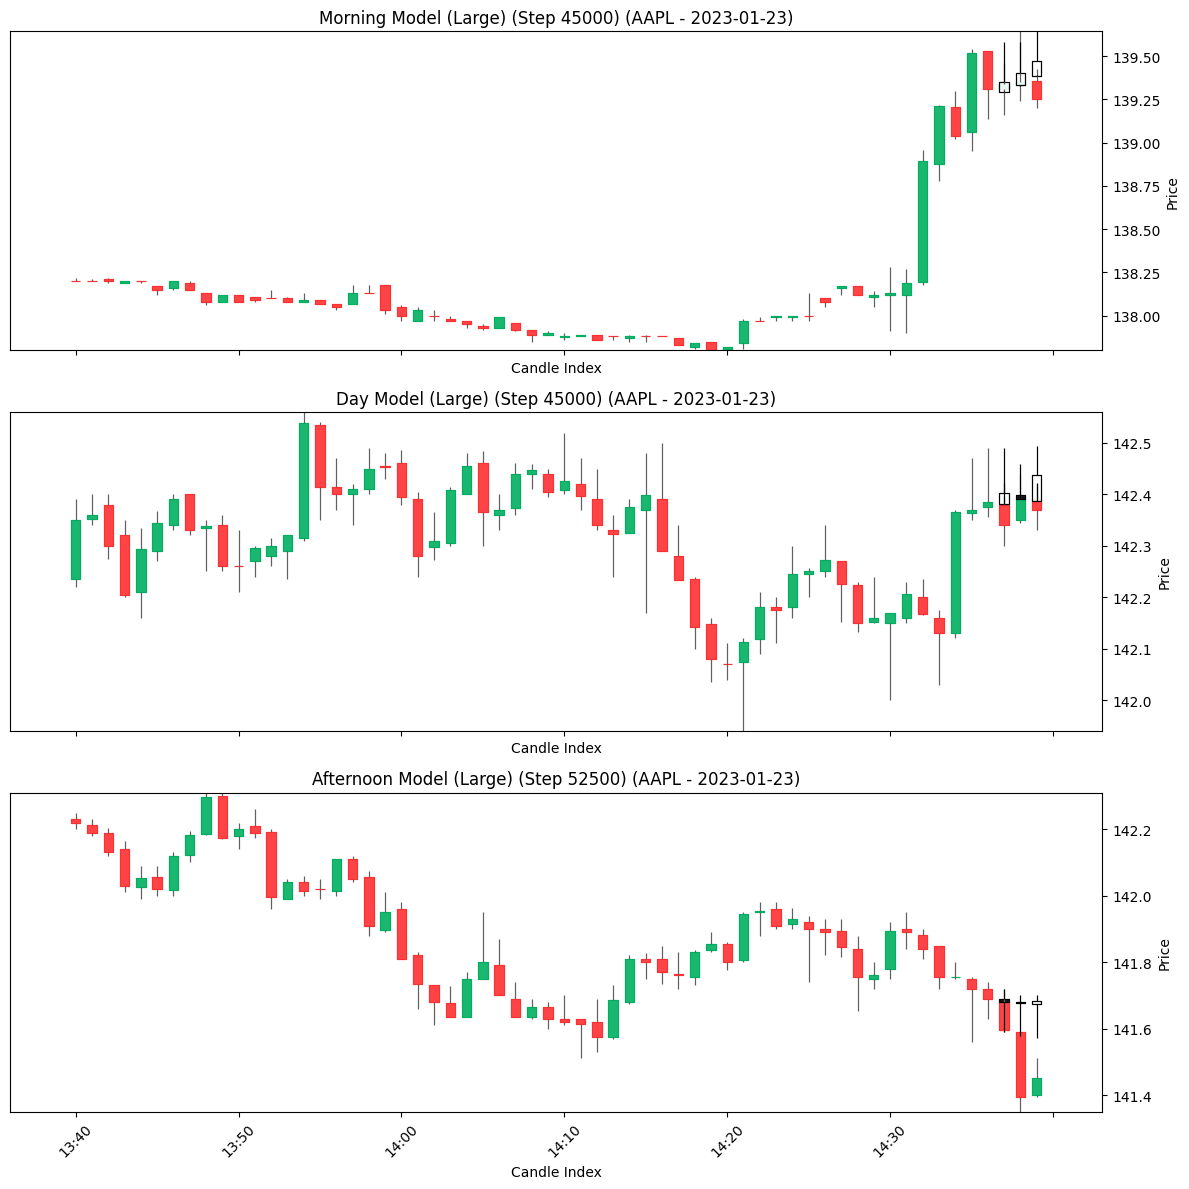

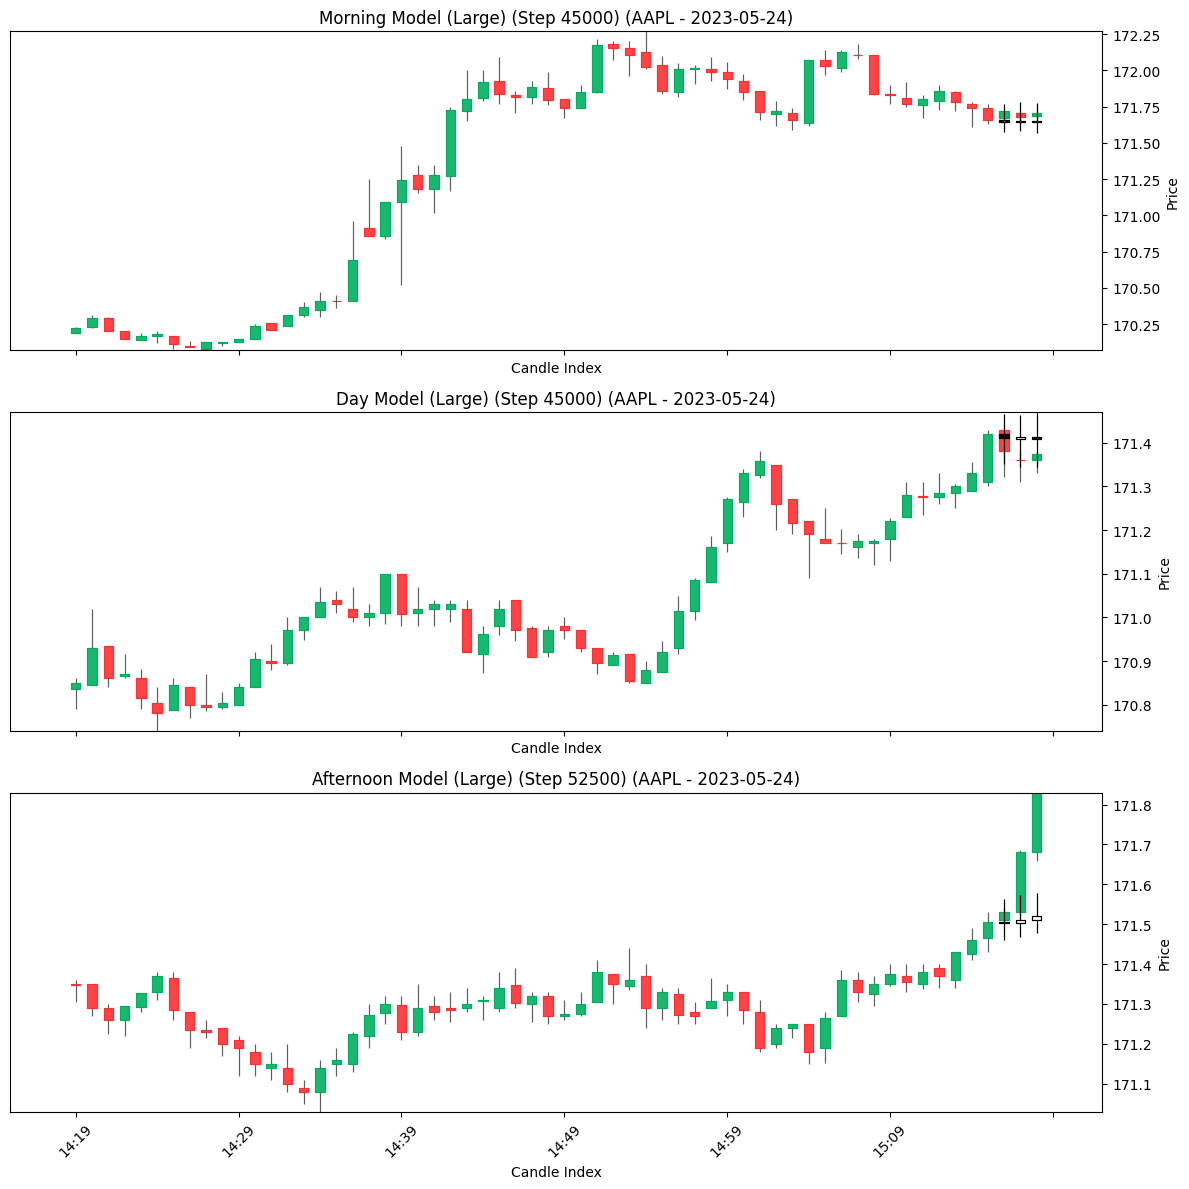

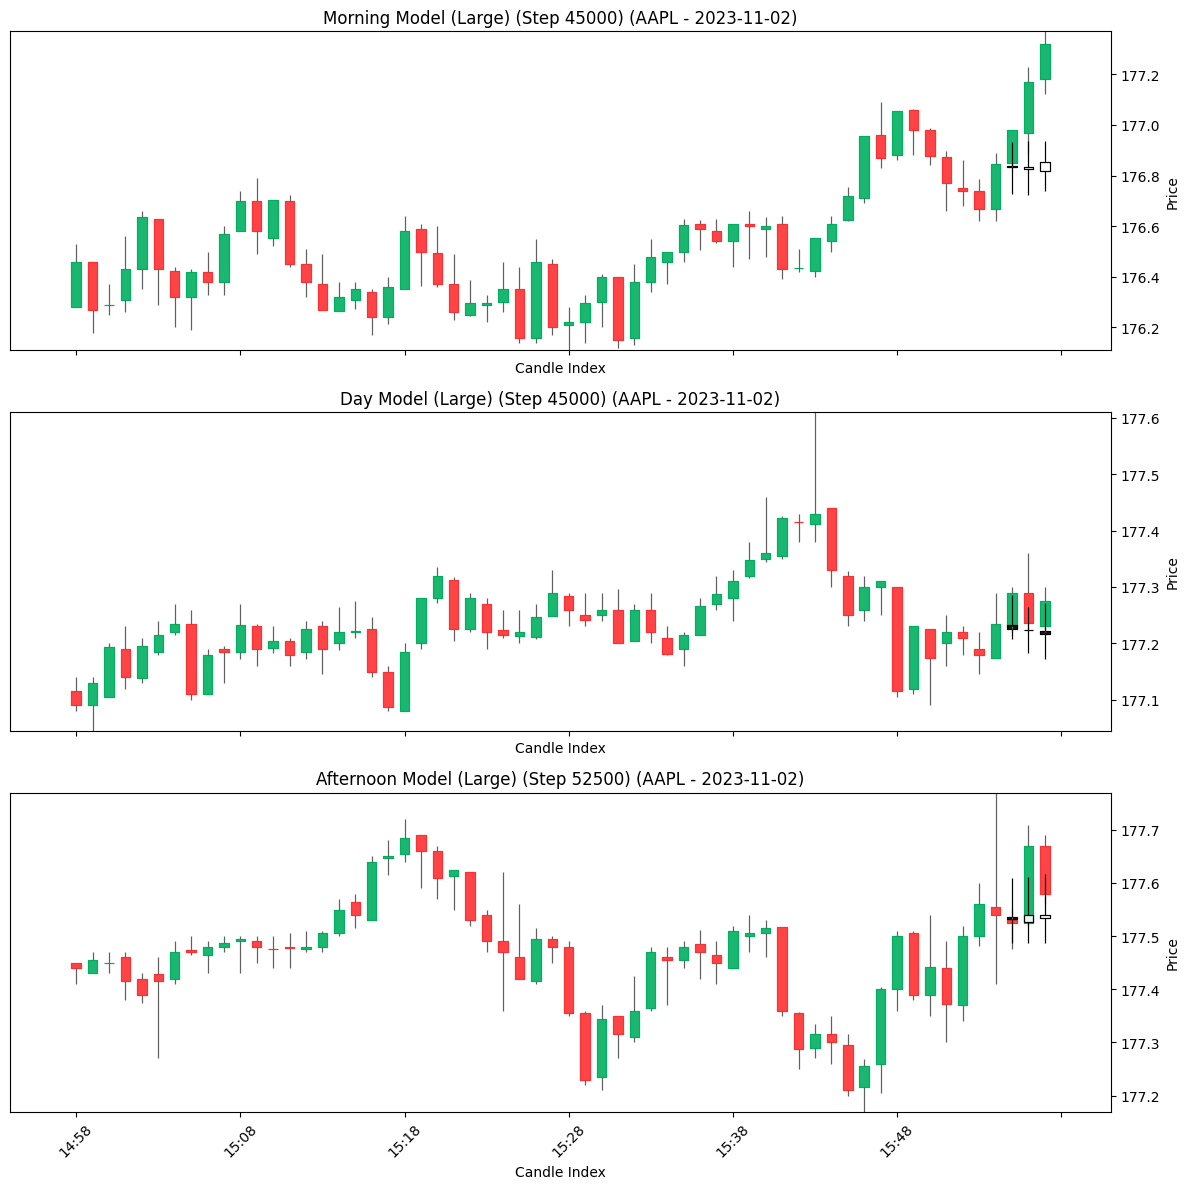

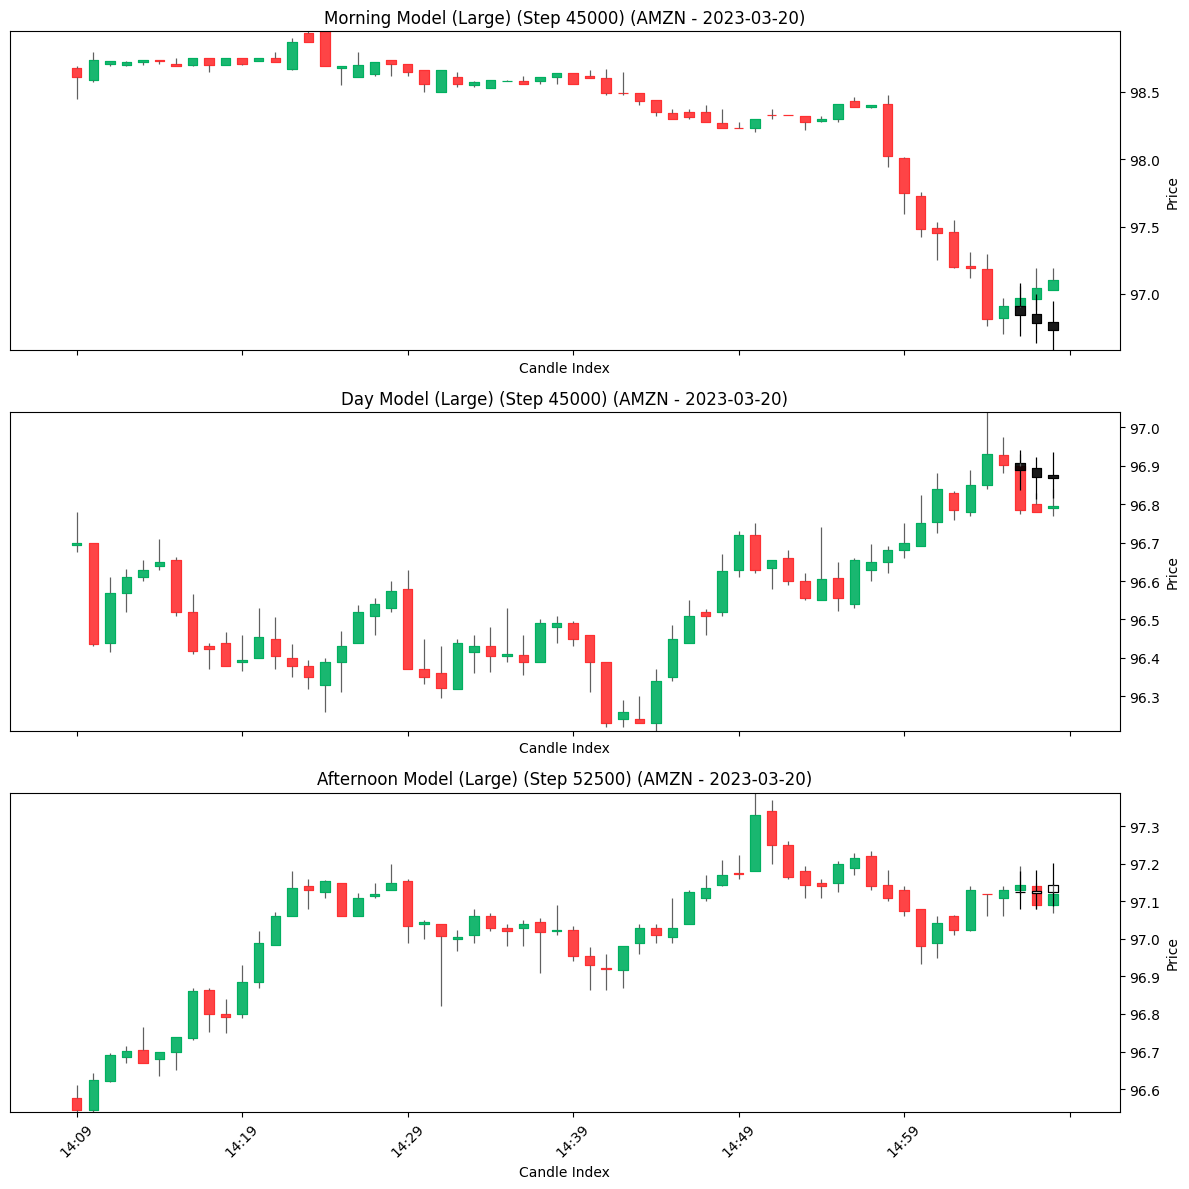

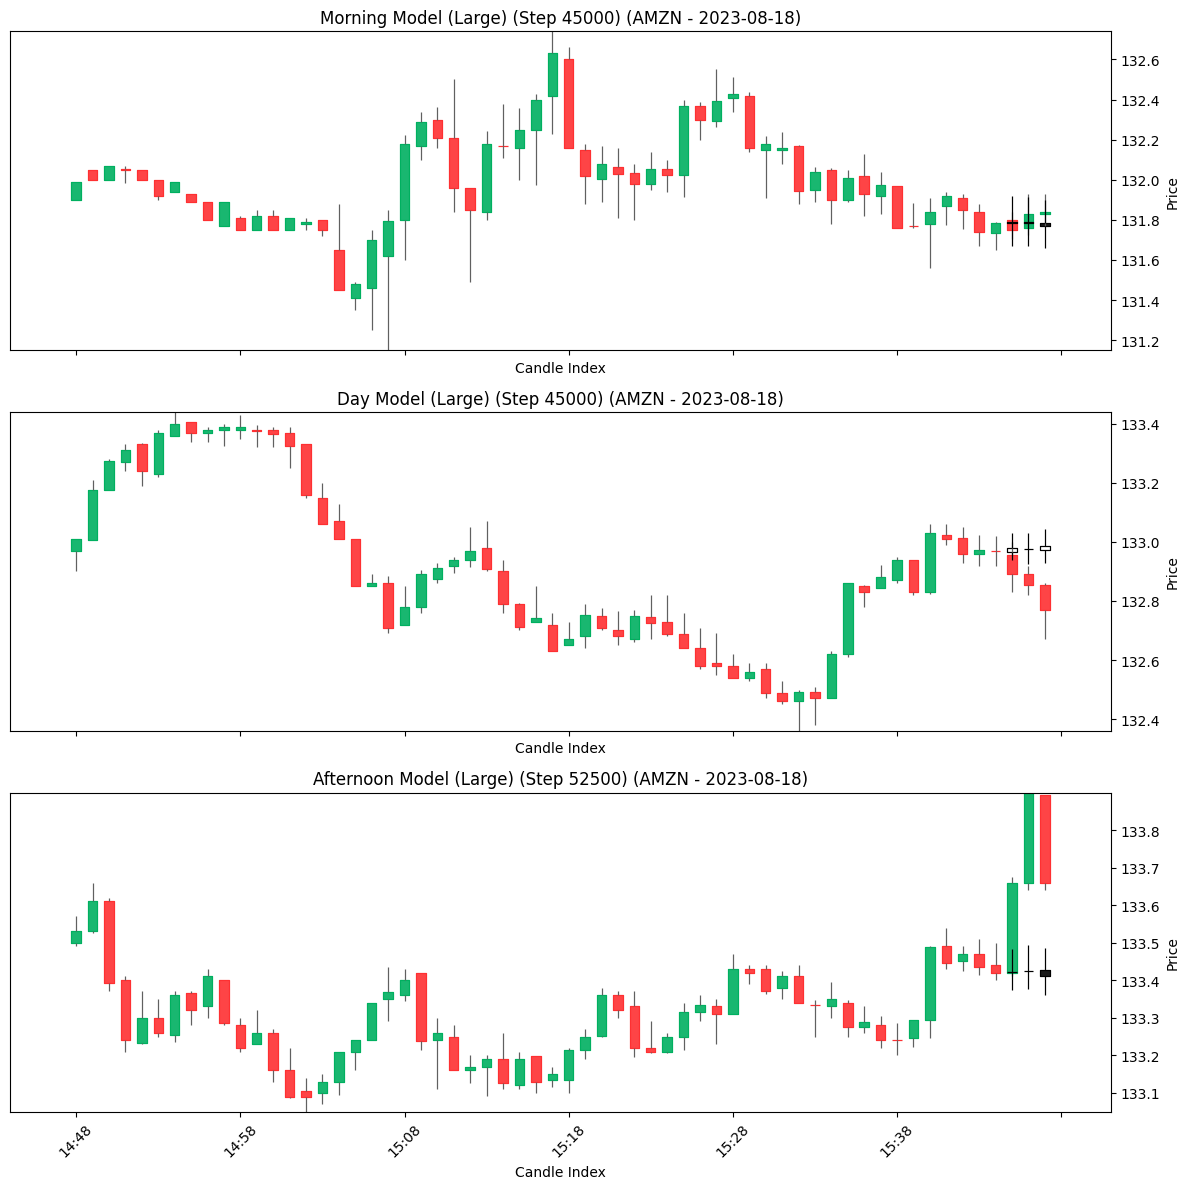

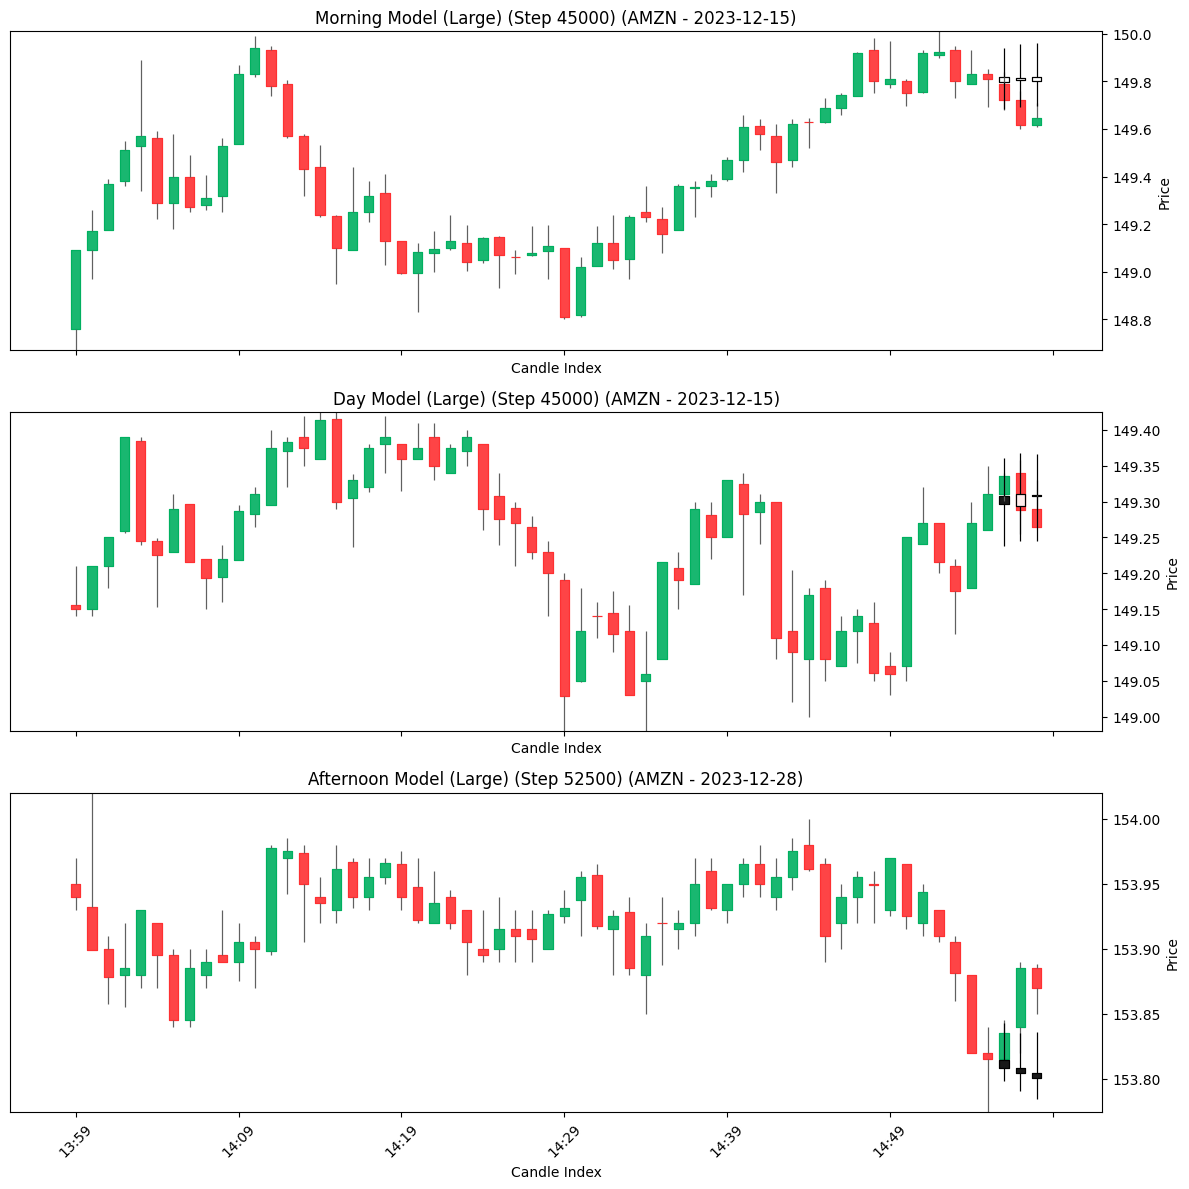

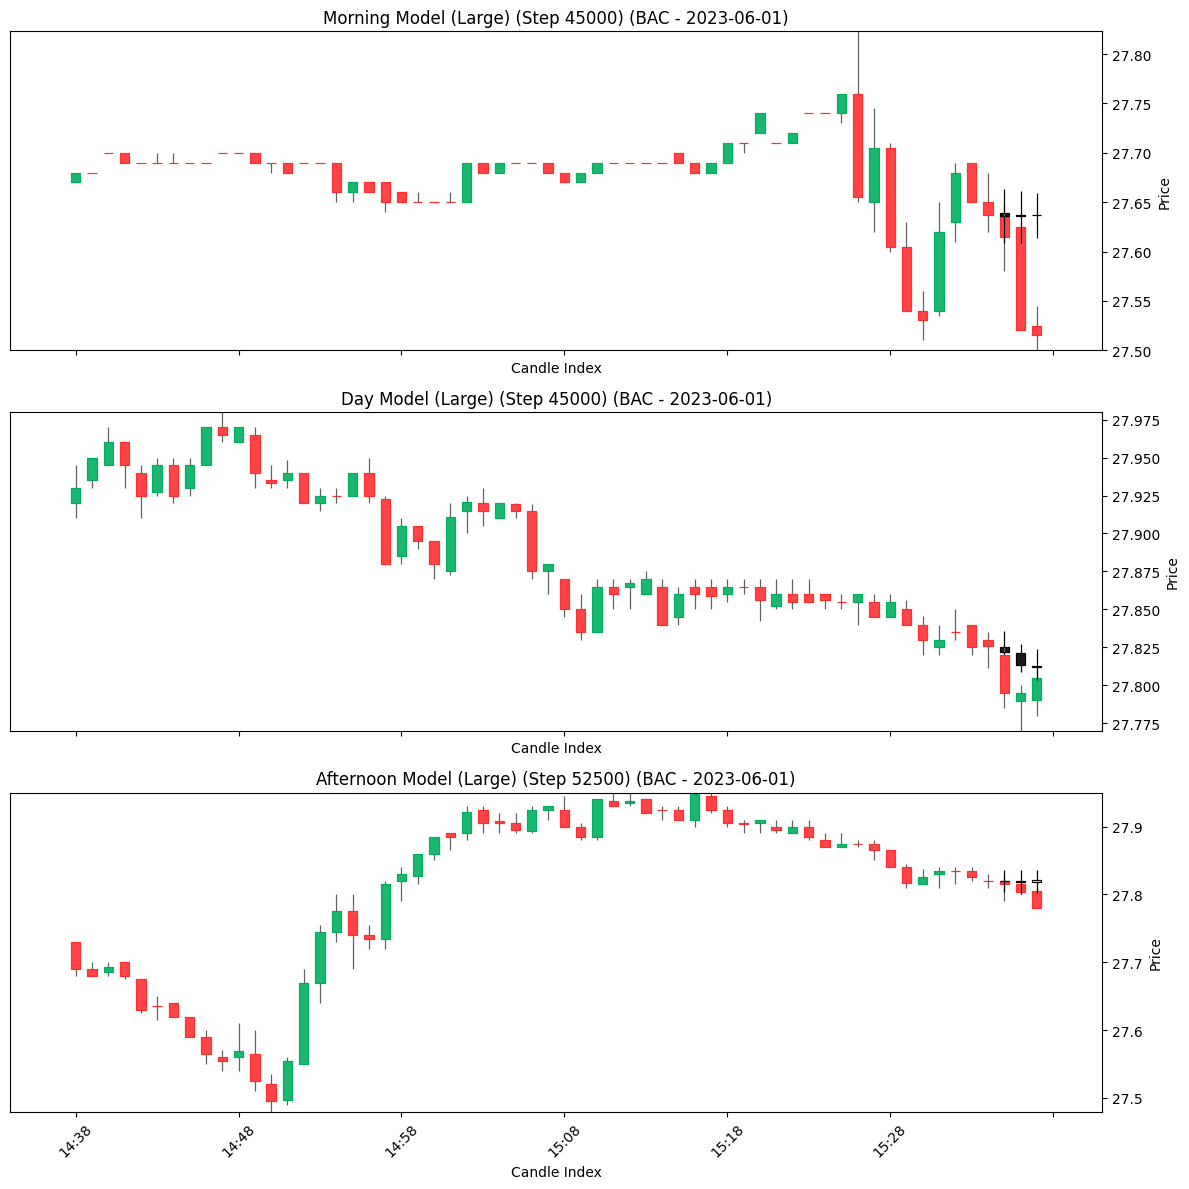

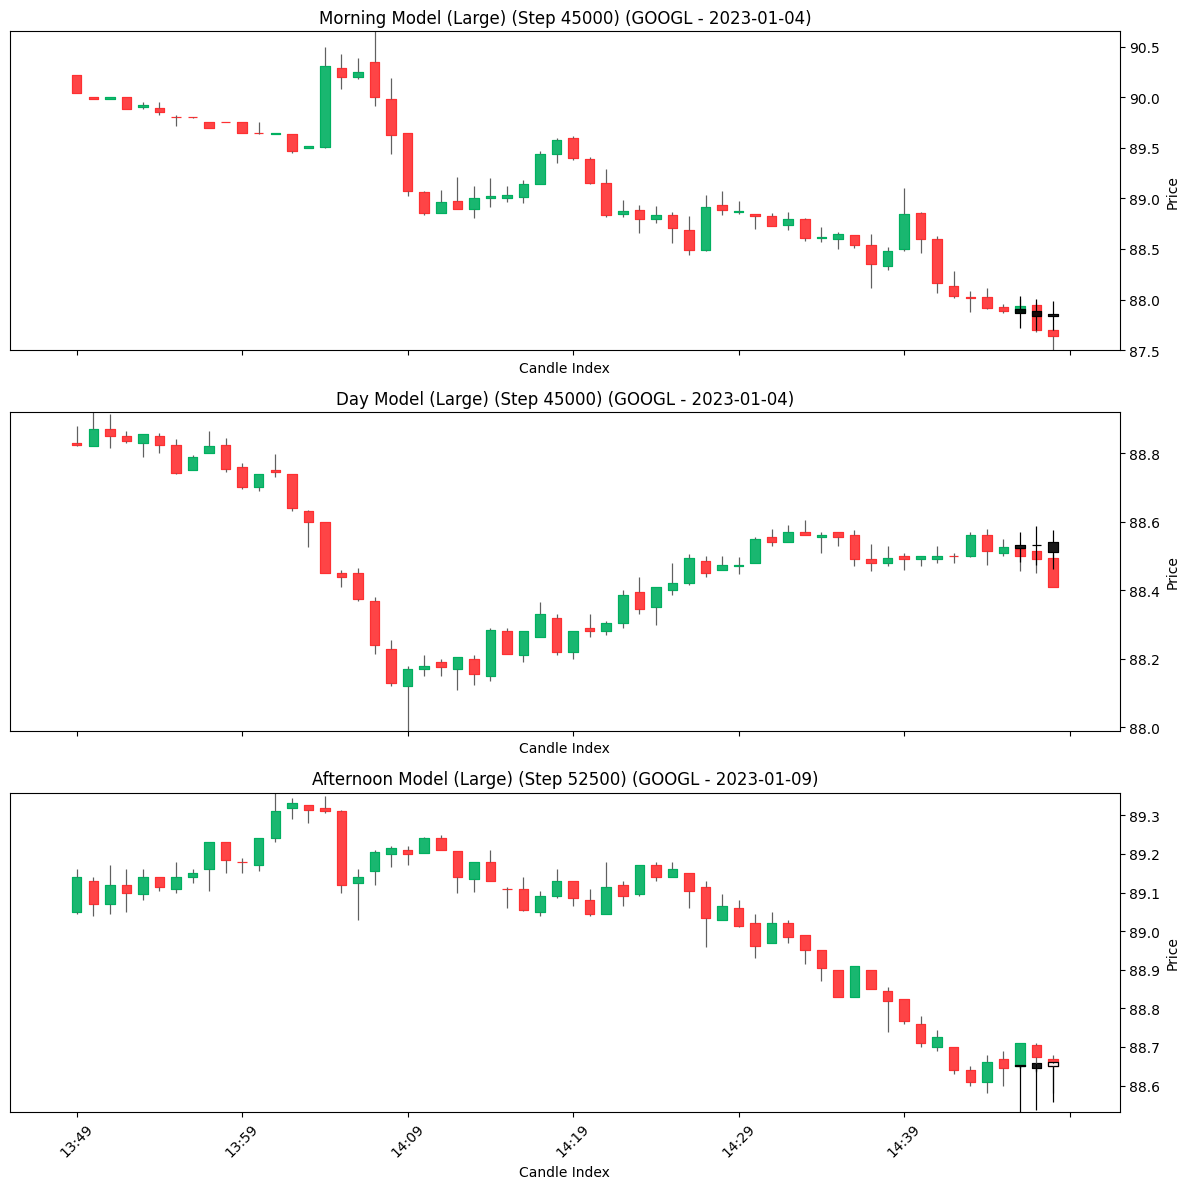

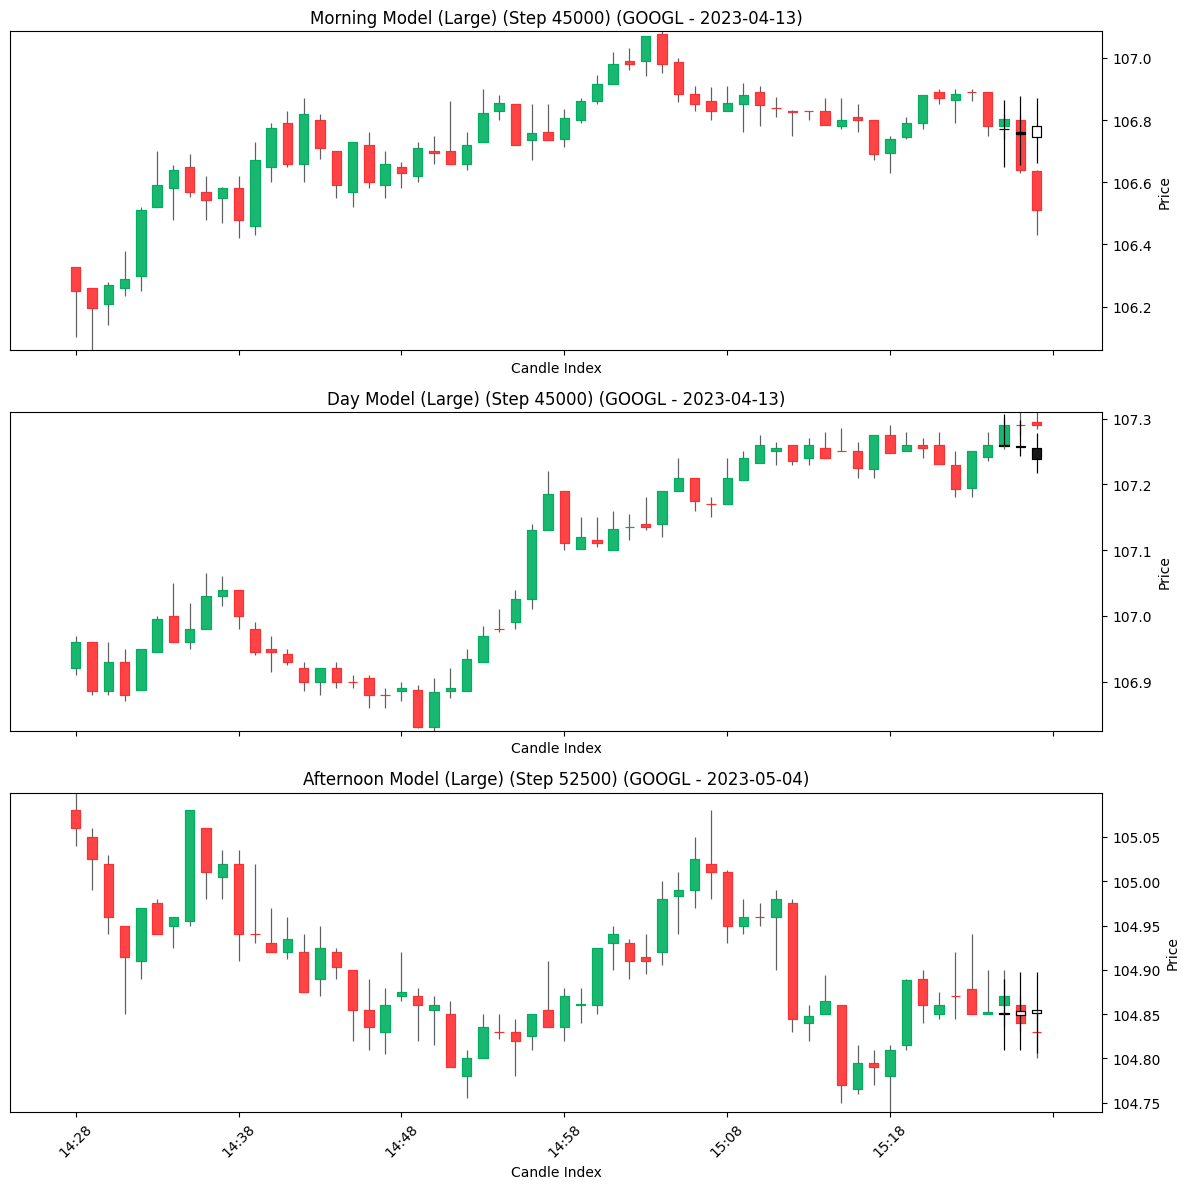

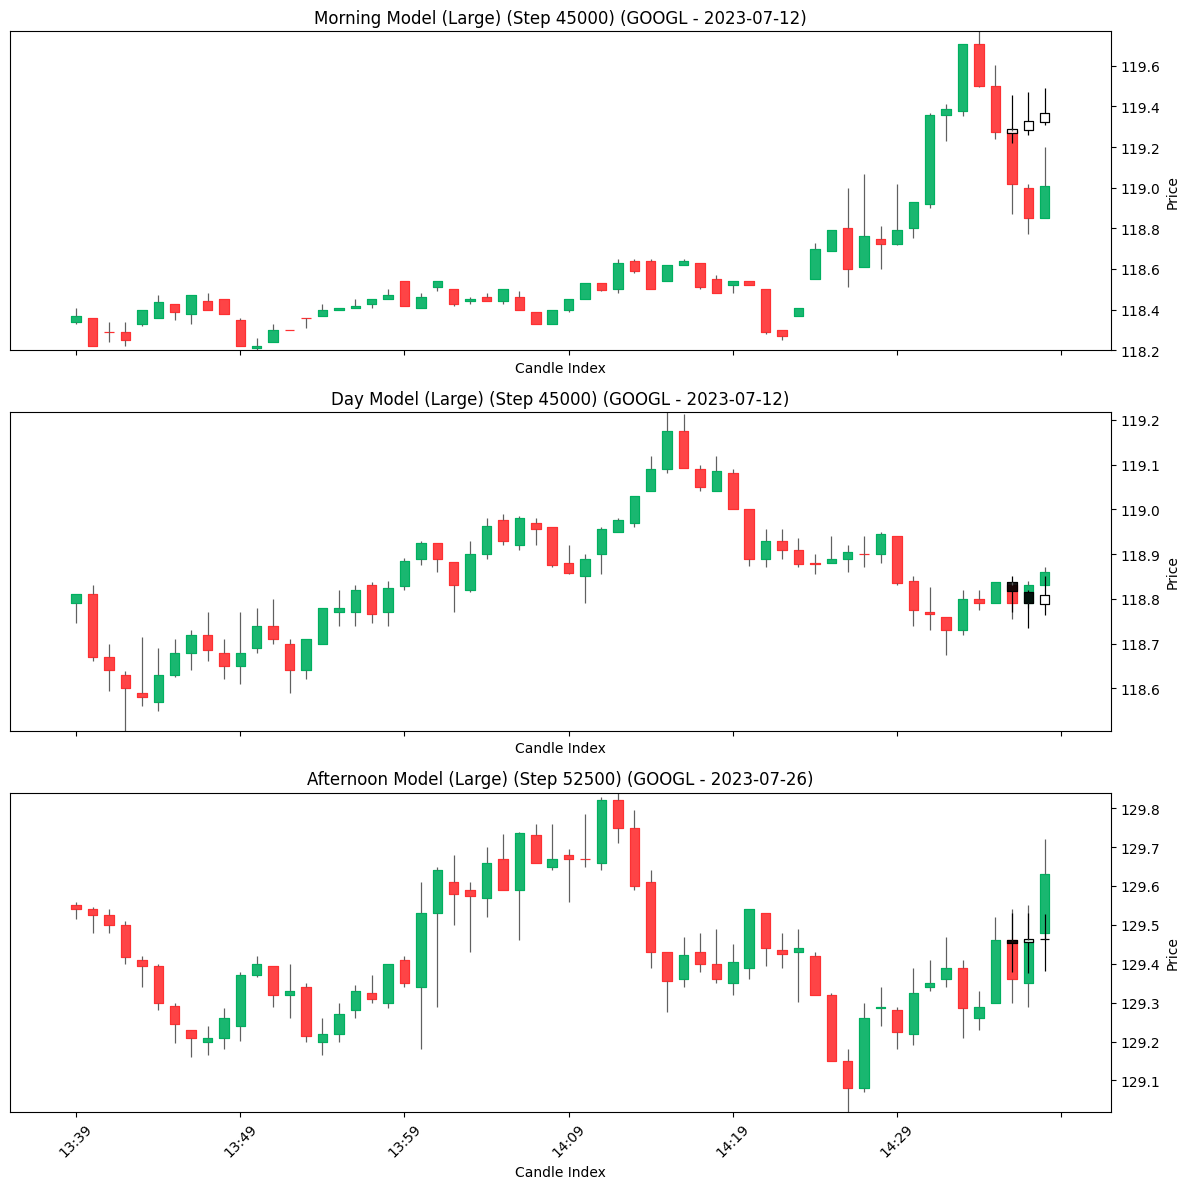

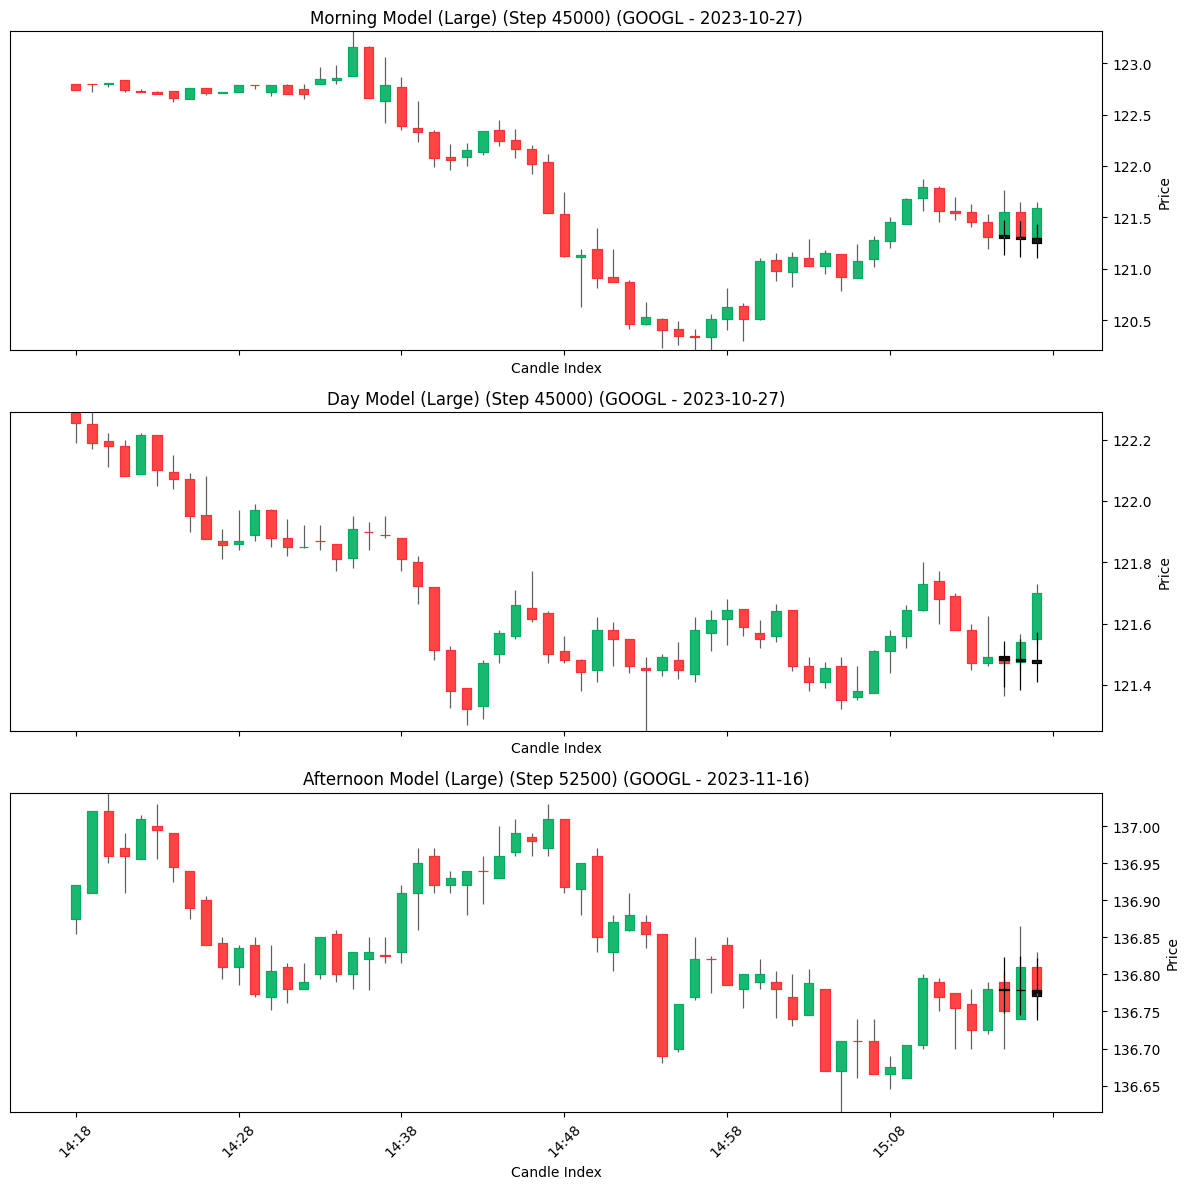

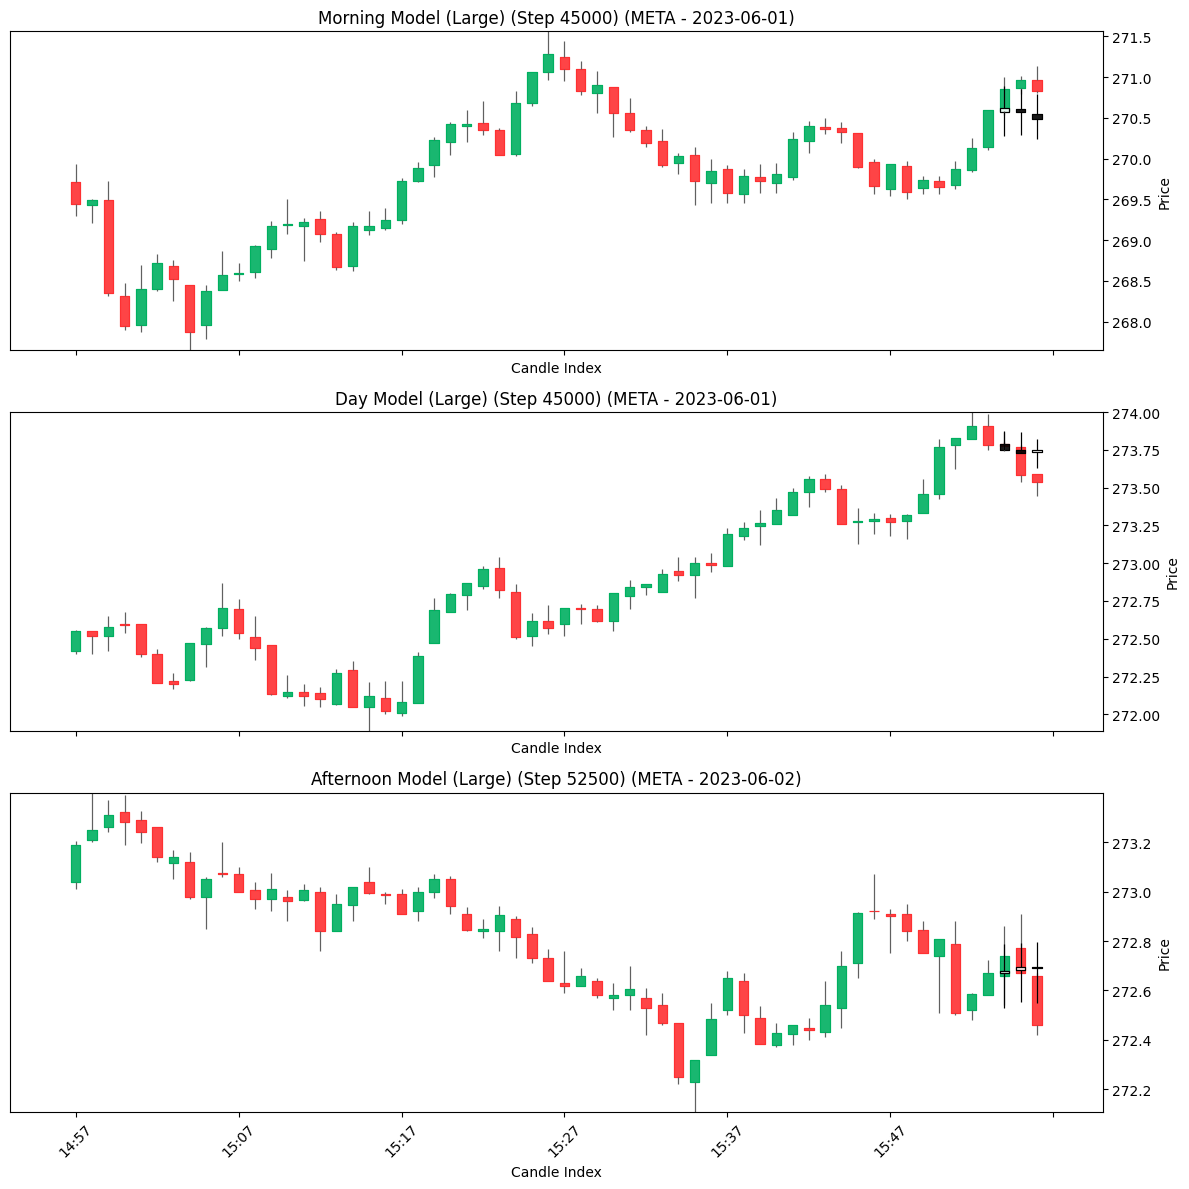

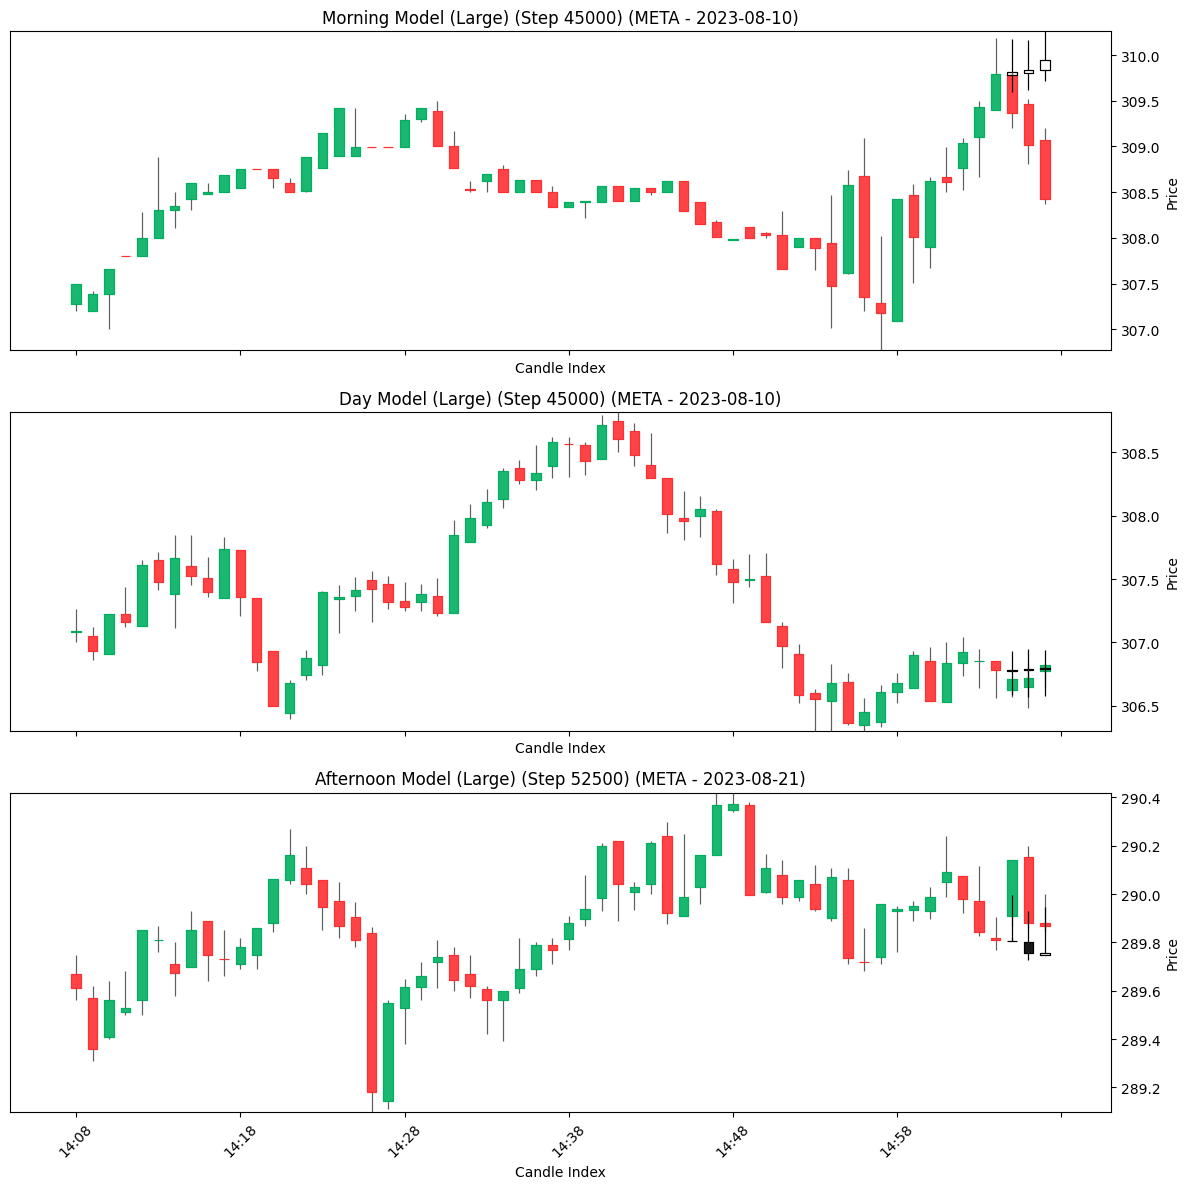

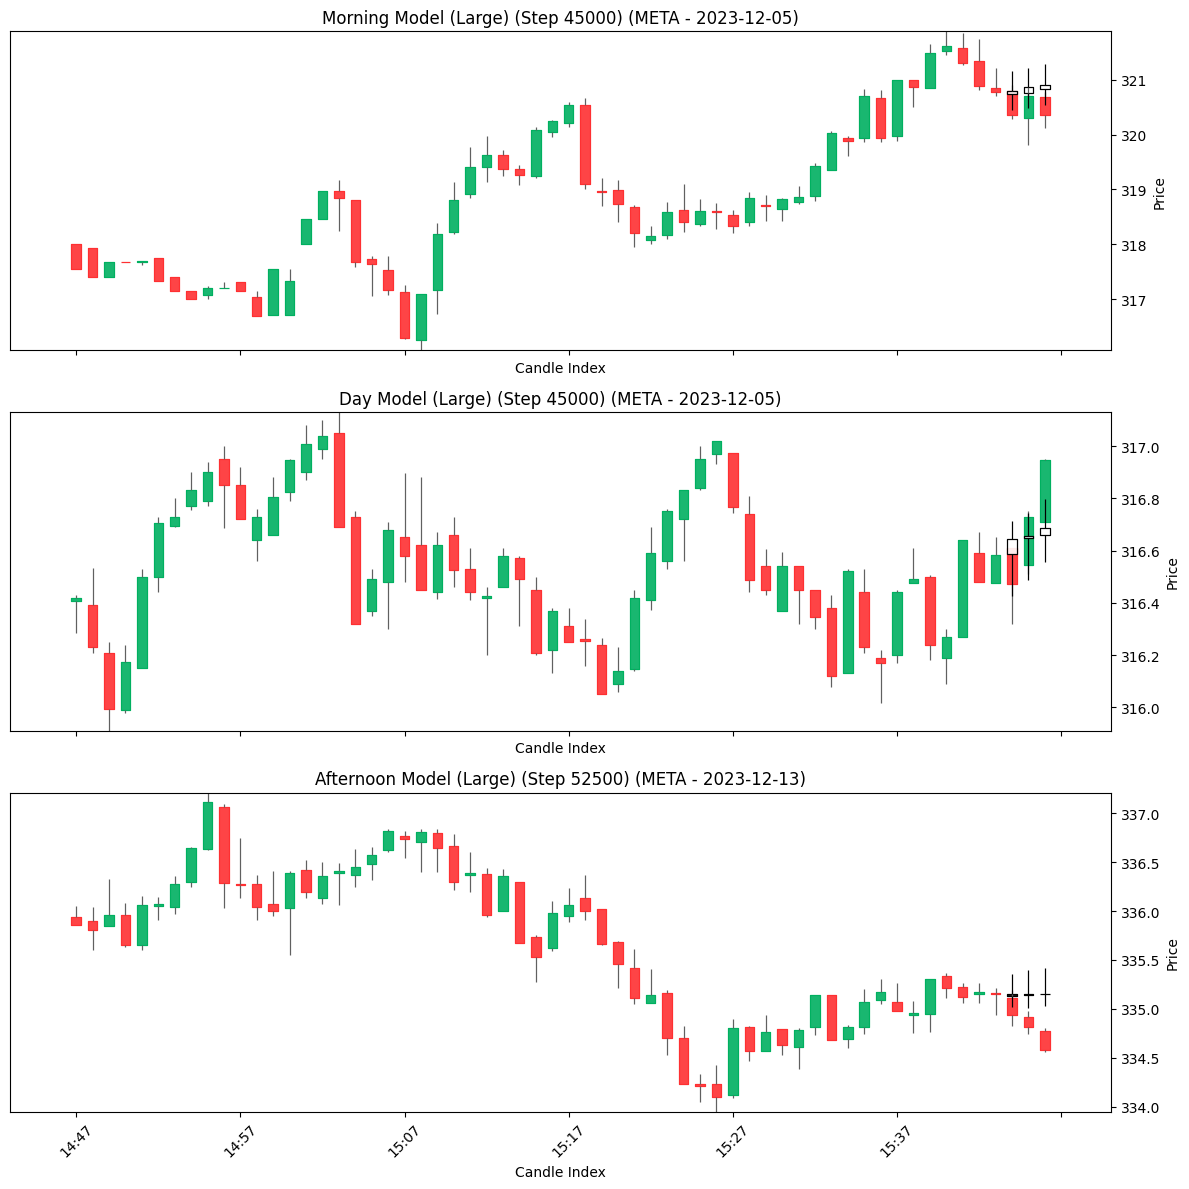

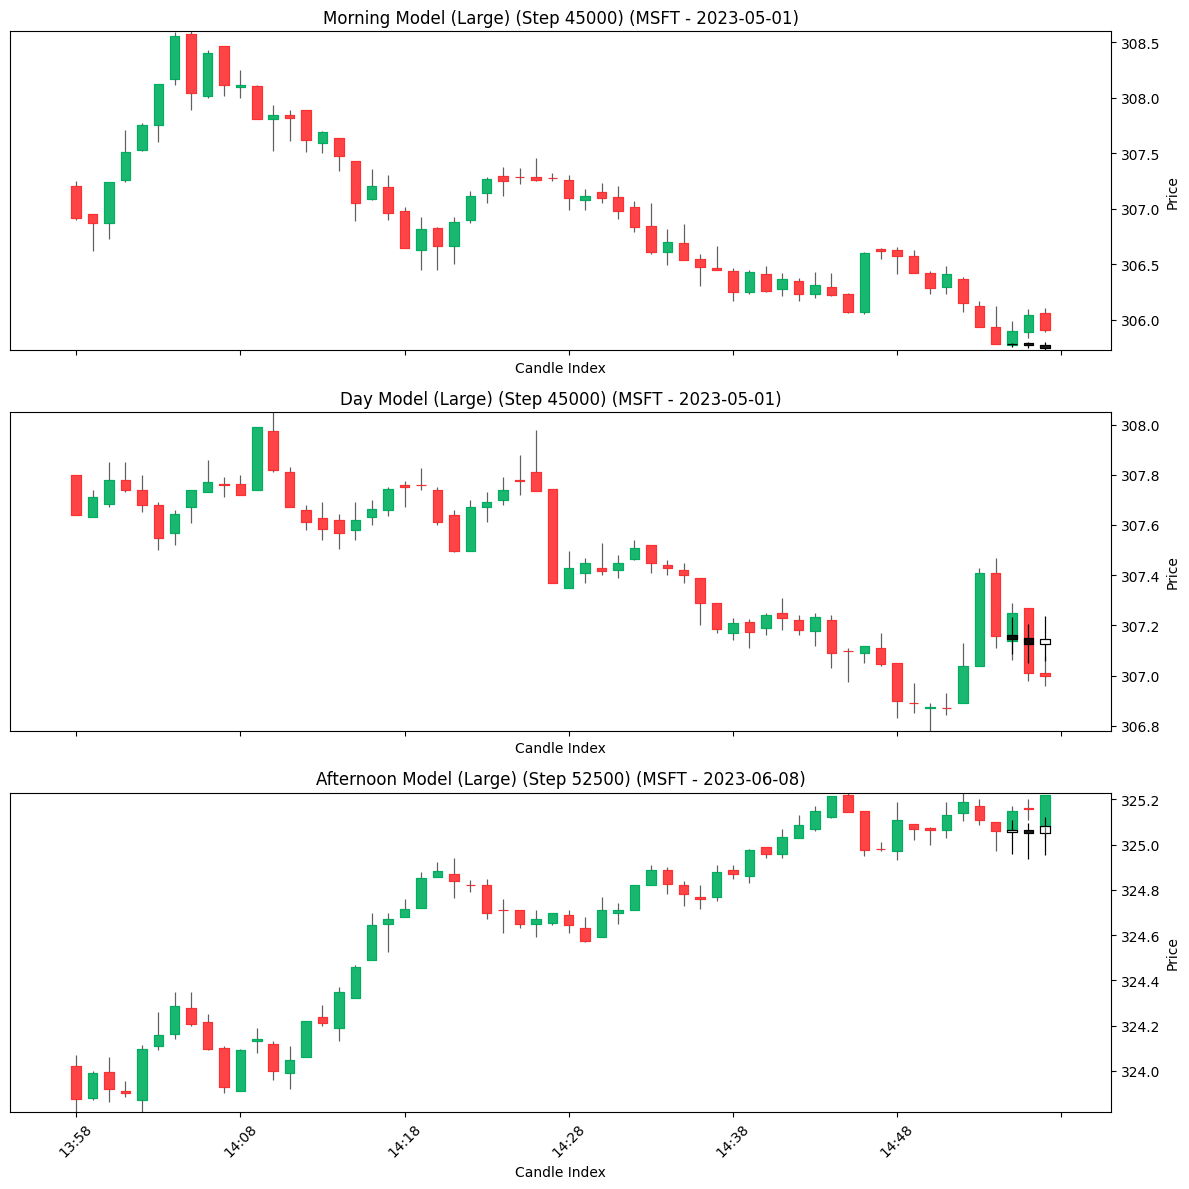

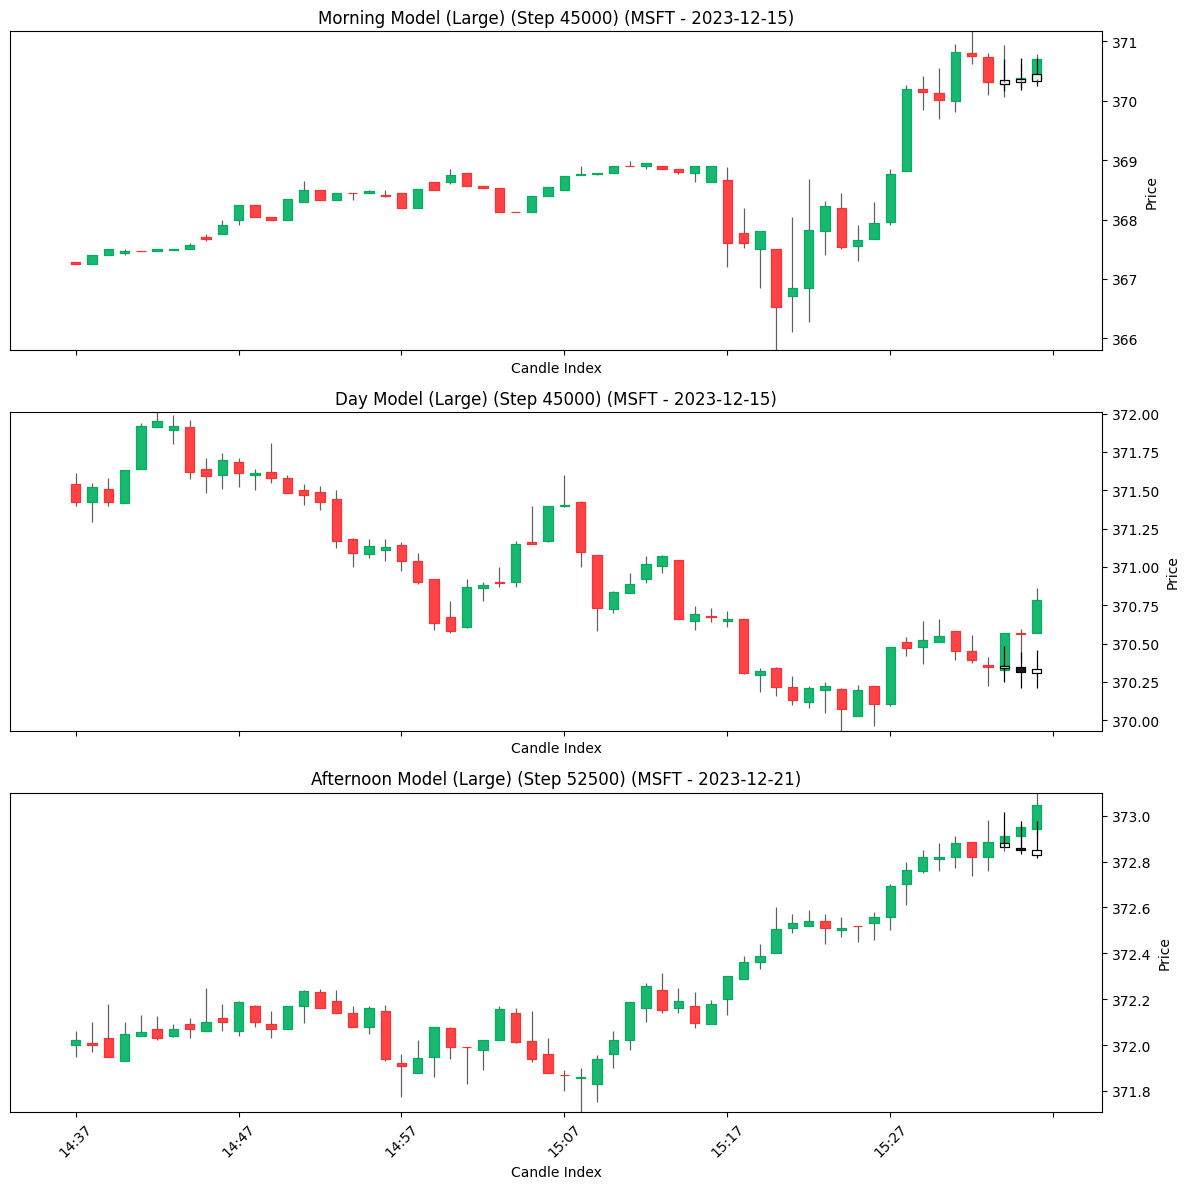

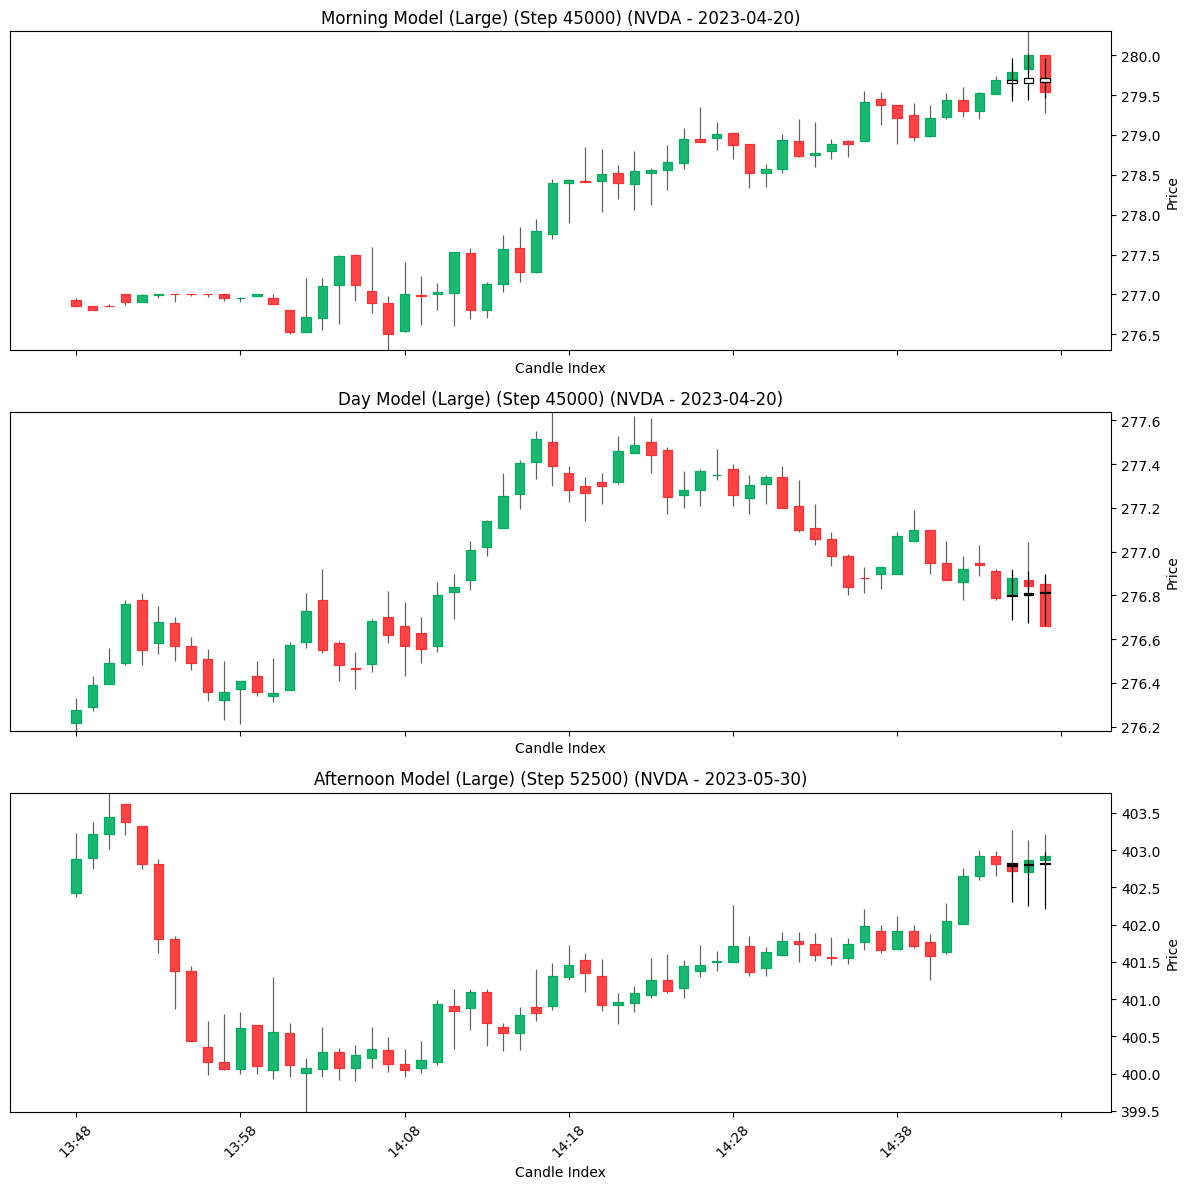

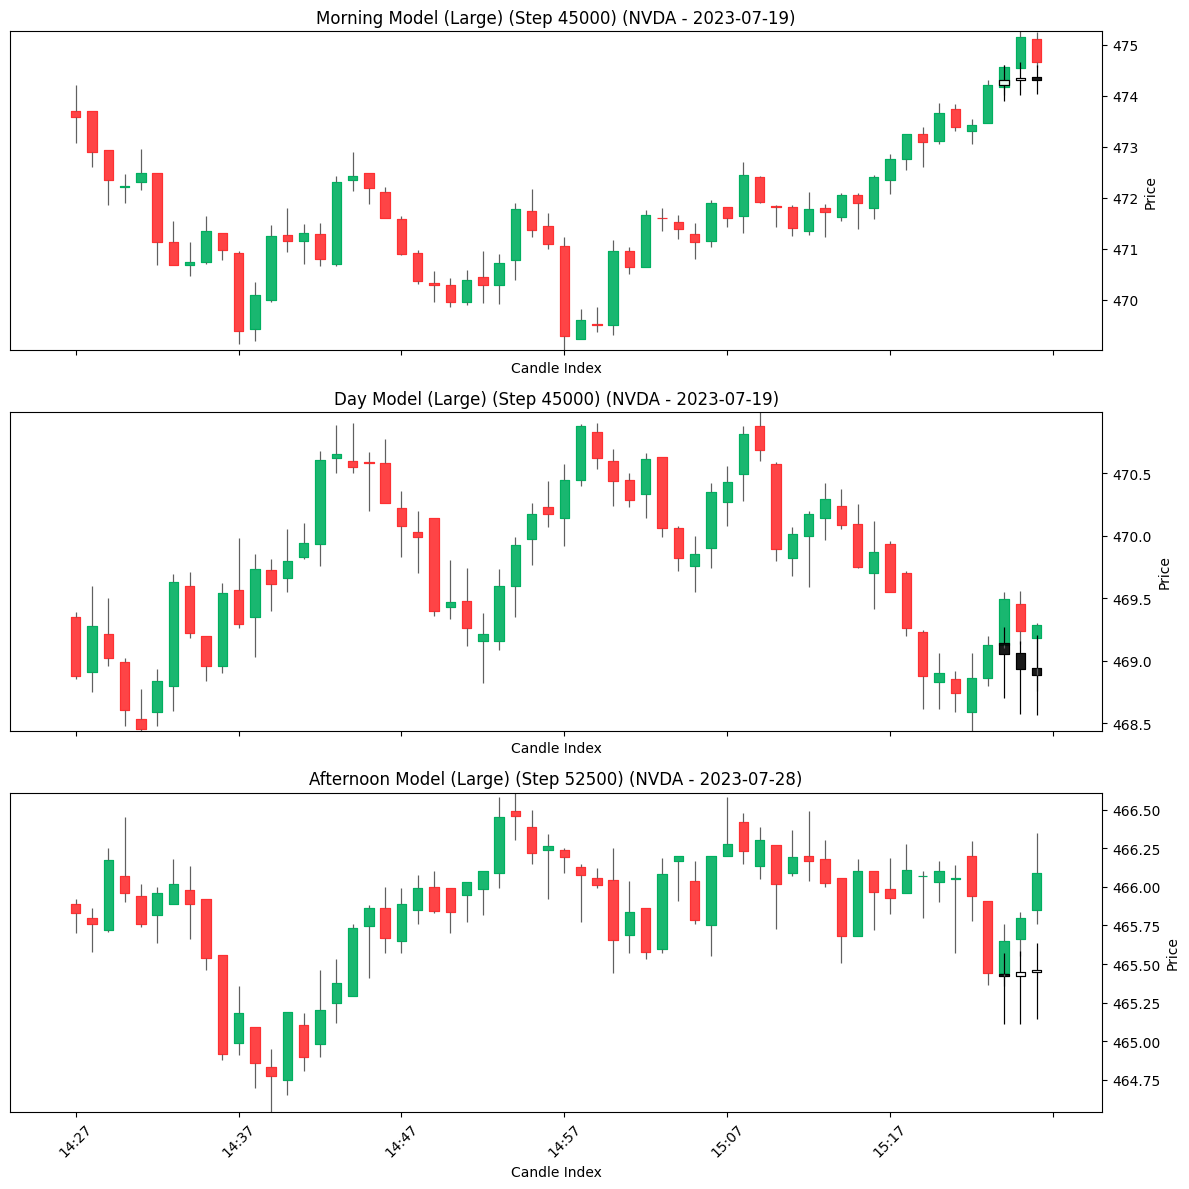

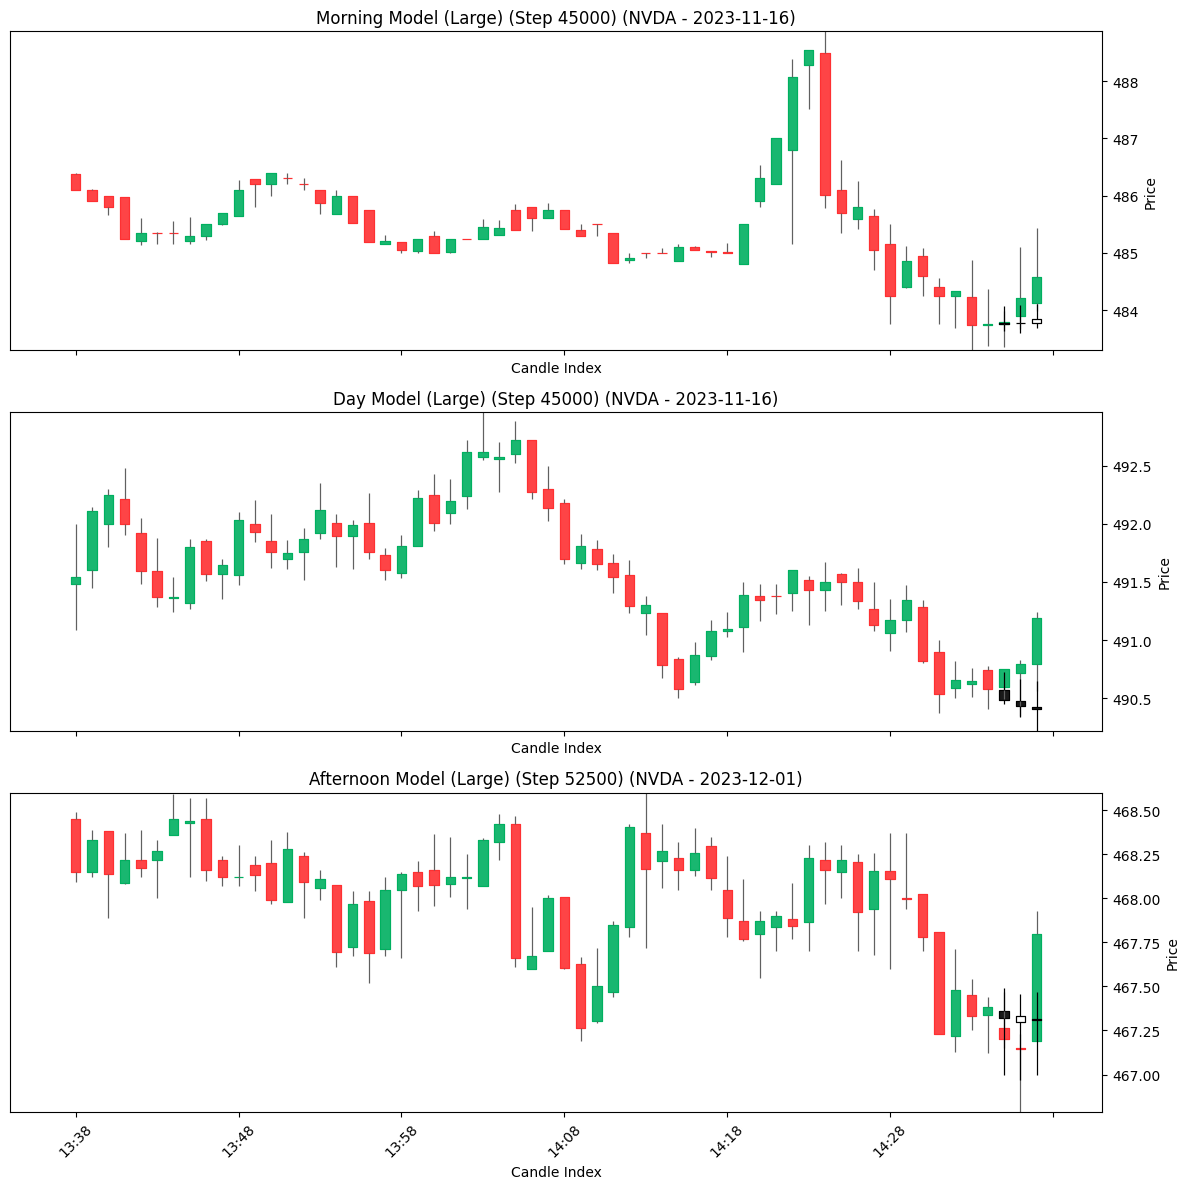

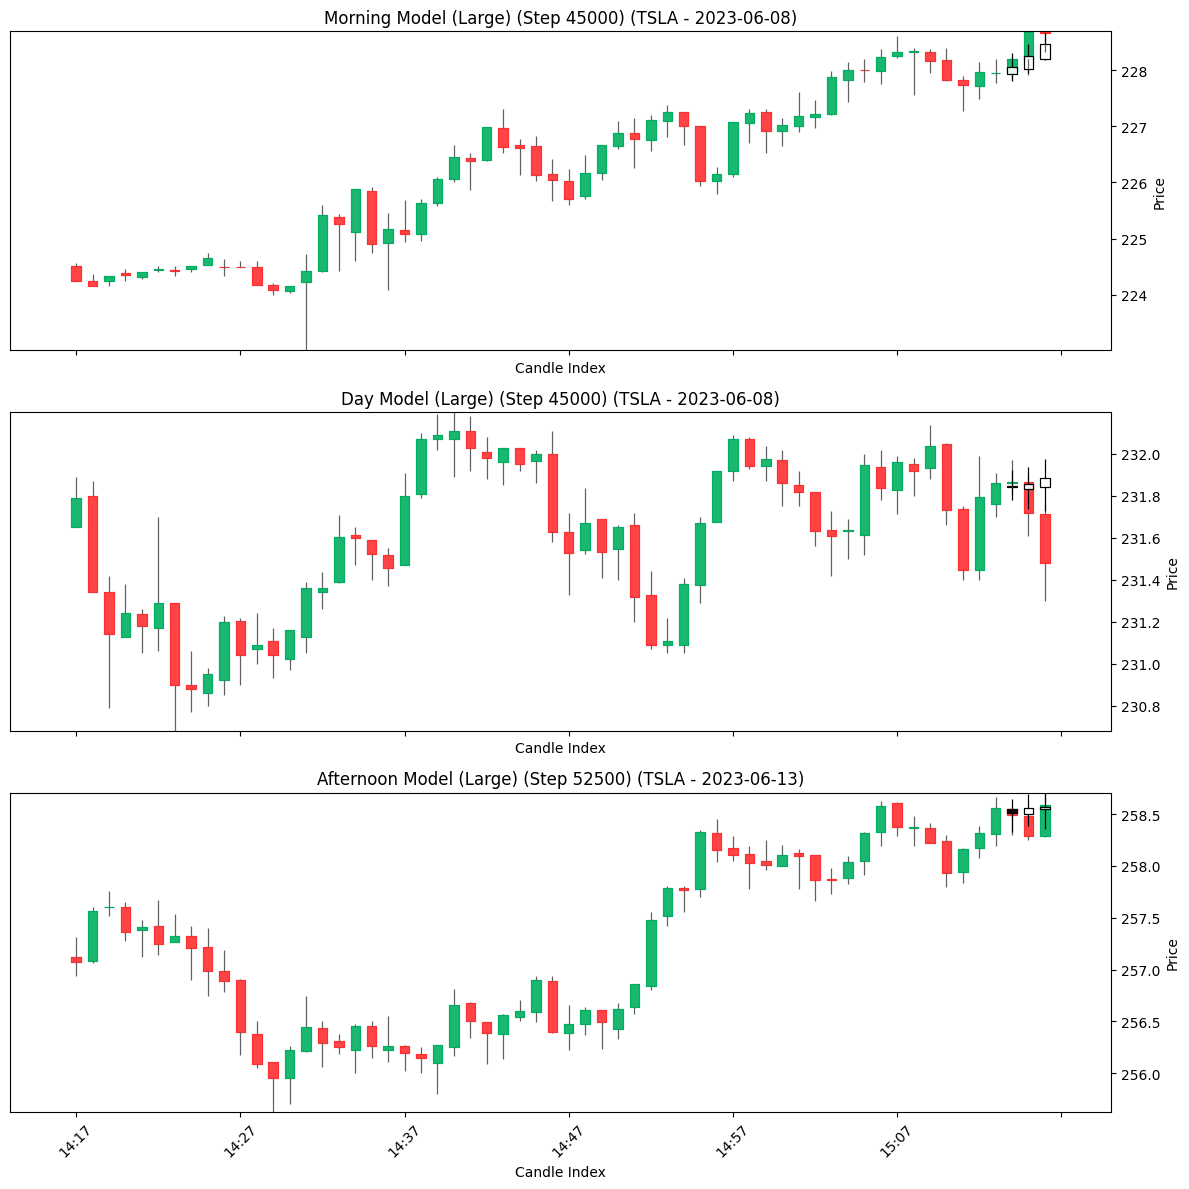

In [144]:
joined_dict = morning_model_dict | day_model_dict | afternoon_model_dict

for i in range(7, len(morning_dataset), (len(morning_dataset) - 10) // 20):
    try:
        infer_and_plot(i, joined_dict)
    except IndexError:
        pass

In [137]:
# Now, we want to plot the loss of each model, based on the time of day. We want to compare
# each model up against its corresponding pair

from torch.utils.data import DataLoader, ConcatDataset

batch_size = 512
shuffle = False
num_workers = 4

def custom_collate(batch):
    # Convert numpy.datetime64 to integer timestamp
    for sample in batch:
        if "timestamp" in sample:
            sample["timestamp"] = int(sample["timestamp"].astype('int64'))
    
    # Use default_collate to collate the modified batch
    return torch.utils.data.dataloader.default_collate(batch)

morning_dataloader = DataLoader(
    morning_dataset, 
    batch_size=batch_size, 
    shuffle=shuffle, 
    num_workers=num_workers, 
    collate_fn=custom_collate
)

day_dataloader = DataLoader(
    day_dataset, 
    batch_size=batch_size, 
    shuffle=shuffle, 
    num_workers=num_workers, 
    collate_fn=custom_collate
)

afternoon_dataloader = DataLoader(
    afternoon_dataset, 
    batch_size=batch_size, 
    shuffle=shuffle, 
    num_workers=num_workers, 
    collate_fn=custom_collate
)


In [145]:
from tqdm import tqdm

def get_dataloader(tag: str):
    print(tag)
    match tag:
        case "MORNING":
            return morning_dataloader
        case "DAY":
            return day_dataloader
        case "AFTERNOON":
            return afternoon_dataloader
        case _:
            raise ValueError(f"INVALID TAG {tag}")

results = {
    model_name: {
        'dataloader': get_dataloader(model_dict['tag']),
        'model': model_dict['model'],
        'timestamps': torch.empty(0),
        'context': torch.empty(0),
        'futures': torch.empty(0),
        'forecasts': torch.empty(0),
    }
    for model_name, model_dict in joined_dict.items()
}

MORNING
DAY
AFTERNOON


In [146]:
for model_name, results_dict in results.items():
    dataloader = results_dict['dataloader']

    # Load model onto GPU
    model = results_dict['model']
    model.to('cuda')
    
    print(f"Evaluating {model_name}")
    for batch in tqdm(dataloader, total=len(dataloader)):
        
        # Get data for batch
        _context = batch['past_values'].to('cuda')
        _futures = batch['future_values'].to('cuda')
        _timestamps = batch['timestamp']

        # Run Inference
        with torch.no_grad():
            # Send context to GPU for inference
            _forecasts = model(_context)

        # Send data back to CPU
        _context = _context.to('cpu')
        _futures = _futures.to('cpu')
        _forecasts = _forecasts.prediction_outputs.to('cpu')

        # Update the results dictionary
        results[model_name]['timestamps'] = torch.cat((results[model_name]['timestamps'], _timestamps), dim=0)
        results[model_name]['context'] = torch.cat((results[model_name]['context'], _context), dim=0)
        results[model_name]['futures'] = torch.cat((results[model_name]['futures'], _futures), dim=0)
        results[model_name]['forecasts'] = torch.cat((results[model_name]['forecasts'], _forecasts), dim=0)

    # Send model back to cpu, to keep mem clean
    model.to('cpu')

Evaluating Morning Model (Large) (Step 45000)


100%|██████████| 33/33 [00:12<00:00,  2.66it/s]


Evaluating Day Model (Large) (Step 45000)


100%|██████████| 33/33 [00:12<00:00,  2.66it/s]


Evaluating Afternoon Model (Large) (Step 52500)


100%|██████████| 33/33 [00:12<00:00,  2.68it/s]


In [147]:
ts_results = {}
torch.set_printoptions(sci_mode=False)

for model_name, res in results.items():
    x = res['context']
    y_obs = res['futures']
    y_pred = res['forecasts']
    timestamps = res['timestamps']

    print(f"Processing Results for {model_name}")

    # Convert timestamps to pandas Timestamps
    ts_vals = (timestamps // 1000000).numpy()
    ts_series = pd.to_datetime(ts_vals, unit='ms', utc=True).tz_convert("America/New_York")

    # Create ts_id for each timestamp, rounded to the nearest 10 minutes
    ts_ids = (ts_series.floor('10min')).strftime("%H-%M")
    
    # Get unique ts_ids
    unique_ts_ids = ts_ids.unique()
    

    # Iterate over unique ts_ids
    for ts_id in unique_ts_ids:
        # Get indices of timestamps matching the current ts_id
        indices = (ts_ids == ts_id)

        # Extract relevant data for the current ts_id
        context_data = x[indices]
        futures_data = y_obs[indices]
        forecasts_data = y_pred[indices]

        val = ts_results.get(ts_id, None)
        if val is None:
            val = {}
            ts_results[ts_id] = val
        
        # Store the data in ts_results dictionary
        ts_results[ts_id][model_name] = {
            'context': context_data,
            'futures': futures_data,
            'forecasts': forecasts_data
        }

loss_results = []
for ts_id, models in tqdm(ts_results.items(), total=len(ts_results)):
    for model_name, values in models.items():
        context = values['context']
        futures = values['futures']
        forecasts = values['forecasts']
    
        loss = custom_loss(context, forecasts, futures)
        pnl_loss = theta_single_pnl(context, forecasts, futures)

        loss_results.append({'ts_id': ts_id, 'loss': pnl_loss[1].mean(), 'model': model_name})

Processing Results for Morning Model (Large) (Step 45000)
Processing Results for Day Model (Large) (Step 45000)
Processing Results for Afternoon Model (Large) (Step 52500)


100%|██████████| 29/29 [00:00<00:00, 615.38it/s]


In [148]:
# Assuming your data is in the format you provided
loss_by_time_df = pd.DataFrame(loss_results)

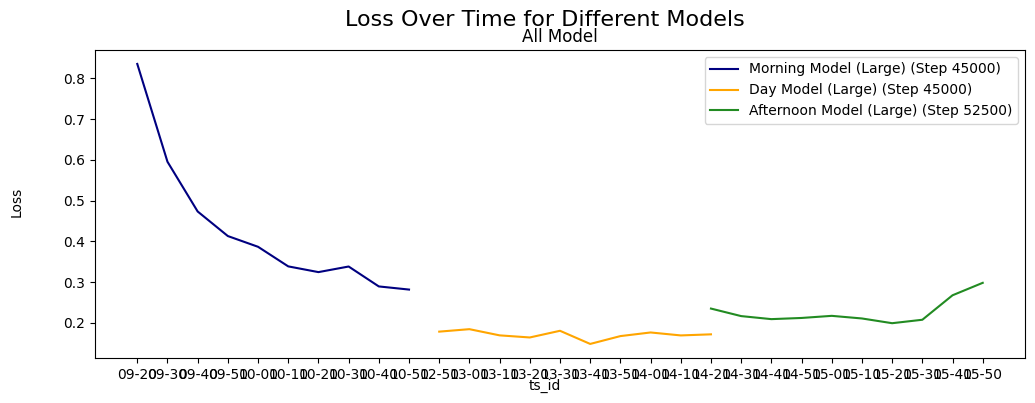

In [151]:
# Pivot the data to create the lines
pivoted = loss_by_time_df.pivot(index='ts_id', columns='model', values='loss')

# Define colors for the morning, day, and afternoon models
morning_colors = ['navy', 'skyblue']
day_colors = ['orange', 'coral']
afternoon_colors = ['forestgreen', 'lightgreen']

# Create a figure with three subplots
fig, ax_main = plt.subplots(1, 1, figsize=(12, 4), sharex=True)

# Plot the morning models
for i, col in enumerate(pivoted.filter(like='Morning').columns):
    ax_main.plot(pivoted.index, pivoted[col], label=col, color=morning_colors[i])

# Plot the day models
for i, col in enumerate(pivoted.filter(like='Day').columns):
    ax_main.plot(pivoted.index, pivoted[col], label=col, color=day_colors[i])

# Plot the afternoon models
for i, col in enumerate(pivoted.filter(like='Afternoon').columns):
    ax_main.plot(pivoted.index, pivoted[col], label=col, color=afternoon_colors[i])

ax_main.set_title('All Model')
ax_main.legend()

# Set labels and title
fig.text(0.5, 0.04, 'ts_id', ha='center', va='center')
fig.text(0.06, 0.5, 'Loss', ha='center', va='center', rotation='vertical')
fig.suptitle('Loss Over Time for Different Models', fontsize=16)

plt.show()

In [ ]:
# Get the P/L of the model on all occasions where it predicted a 0.25% move in 3 candles